In [1]:
import sys
import os
import gc
import collections

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib import animation, rc
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF, Rotator, ROCK_PCA
from xmca.xarray import xMCA  # xarray

import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from itertools import product
import pyproj
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)

/var/folders/6b/9ftjhcg16g19w33zvk7zd7mm0131yc/T/ipykernel_56034/2014078991.py:17: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


Location of all environment packages can be found by running: `module.__file__`
Will require this path to make modifications to source code.

In [ ]:
# xr.__file__

In [2]:
# Define local plotting parameters
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')
plt.rc('text', usetex=True)

## Define directories

In [3]:
# To update following with relative repository paths once data and code is up on Zenodo
# Current version uses the project template on Github.

# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS
# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'
# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Relative directory paths for Data and Figures
figures_folderpath = 'reports/figures/'
interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'
cise_file_path = 'cise_data/'
std_file_path = 'standardized_rec_data/'
temp_rotated_path = 'temp_rotated_eof_data/'

## Input data files and catchment masks for ice shelves

### Catchment boundary masks

In [4]:
# Catchment boundary masks for Antarctica, taken from ice shelf definitions in MPAS-Dev/geometric-features
# Source: https://github.com/MPAS-Dev/geometric_features/tree/main/geometric_data
# These have been combined into one file with 133 defined regions (polygons and multipolygons), 
# readable via the Geopandas package

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# Convert to south polar stereographic projection
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); # This has been deprecated
icems = iceshelvesmask.to_crs('epsg:3031');
crs = ccrs.SouthPolarStereo();

### Plot catchment boundaries

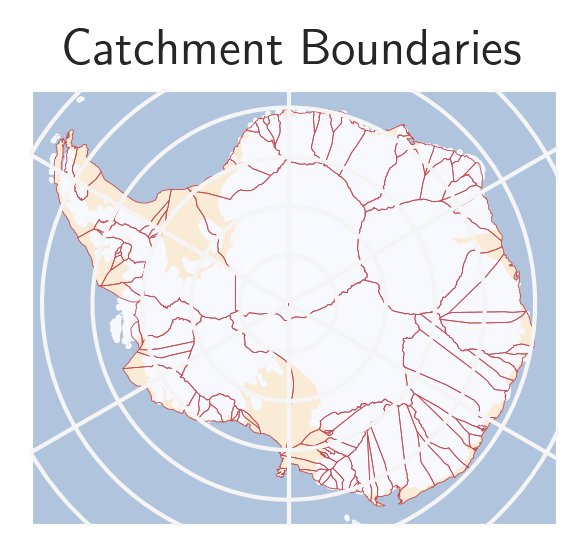

In [5]:
# Plot boundaries

plt.figure(figsize=(5,5))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

### Ocean forcing data

In [6]:
# Original forcing data: raw MPAS-O output, mapped to the 10km resolution grid
# flux is freshwater flux
# ssh is sea surface height, used here as a proxy for ice draft / depth.

# ssh is used to plot the scatterplot of flux vs. draft for different ice shelves 
# and as input for the linear regression used in "dedrafting" the dataset

regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

# Pre-processed data: detrended, deseasonalized, dedrafted
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

# Dedrafted flux
flux_dedrafted = xr.open_dataset(inDirName+
                                 interim_data_folder+
                                 flux_dedrafted_iceshelves_data_path+'iceshelves_dedrafted_total.nc')
flux_dedrafted = flux_dedrafted.timeMonthly_avg_landIceFreshwaterFlux

# Flux datapoints extracted for individual ice shelves, used for the scatter plots
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")
catchments_scatter_xr = xr.DataArray(catchments_scatter,dims={'basin','x','y'})

# Add reconstructed datasets - seed random

In [ ]:
# Define global operator as area factor based on colatitude
colat = np.cos(np.radians(flux_clean.lat.values))
areafac = colat/sum(sum(colat))
#flux_av = flux_clean*areafac

In [ ]:
flux_av_ts = flux_av.sum(["x","y"])
flux_clean_ts = flux_clean.sum(["x","y"])

In [ ]:
plt.figure(figsize=(25,8))
flux_clean_ts.plot()
flux_av_ts.plot()
r_ts.plot()

In [ ]:
# This may not be necessary!
xreg = xr_linregress(flux_av,flux_clean,dim='time')
b = xreg.intercept
w = xreg.slope

residual = flux_clean-(flux_av*w + b)
r = residual

In [ ]:
r_ts = r.sum(["x","y"])

In [ ]:
%%time
xh0 = areafac
xh0 = xh0/np.sqrt(sum(sum(xh0*xh0)))
# proj0 = r*xh0 # IF USING REGRESSION in previous step
proj0 = flux_clean*xh0
# resids = r - proj0*xh0 # IF USING REGRESSION in previous step
resids = flux_clean - proj0*xh0

In [ ]:
flux_resids = resids

### Convert Freshwater Flux [$kg. m^{-2} s^{-1}$] to Melt Rate [$m.yr^{-1}$]
Assumes density of freshwater $\rho_{fw}$ [$kg/m^3$] = 1000

In [ ]:
sec_per_year = 365*24*60*60
rho_fw = 1000

In [ ]:
resids_m_per_yr = resids*sec_per_year/rho_fw

### Plot sample data for specific ice shelves (melt rate draft dependence)

In [ ]:
# Figure: Melt rate draft dependence for select catchments
# The following indices are taken from 'catchment_scatter', defined as
# Index of catchments in catchment_scatter = Index of catchments in icems - 33

# Sample ice shelves chosen:
# Amery = 1
# George VI = 27
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

# Full list of ice shelves and indices can be obtained by printing icems

catchments = np.array([1,27,28,61,70,83,94,71,22])

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(3,3, figsize=[15, 15])
axs=axs.ravel()

for i in range(9):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=4)
    #axs[i].set_xlabel('Melt Flux (kg / m2 / s)')
    #axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-1000,0) # Specified for consistency across plots, some catchments are not as deep as others
    # Uncomment to set xlim values for easy comparison of forcing magnitudes (varies across ice shelves)
    axs[i].set_xlim(-0.5e-6,2e-5)
    axs[i].set_title(icems.name[33+catchments[i]])
    # axs[i].inset_axes([], projection=crs) does not seem to work, hence the workaround below:
    # Refer here: https://github.com/matplotlib/matplotlib/pull/22608 for future revisions
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r',linewidth=0.4)
    axins.set_axis_off();

axs[0].set_ylabel('Depth (m)'); # Ice Draft?
axs[3].set_ylabel('Depth (m)');
axs[6].set_ylabel('Depth (m)');


axs[6].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[7].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');
axs[8].set_xlabel('Forcing Flux ($kg m^{-1}s^{-2}$)');

# TODO: Convert to m SLE units for flux

# Data Pre-Processing

For time series plots and comparisons, the sum of flux across the spatial domain (or specific ice shelves) is used as a proxy when required. The mean can also be used here, without any loss of information, as the idea is only to compare trendlines.
#### TODO: Verify if this is indeed true

However, this might not be possible once the data is normalized, as the magnitude of data is removed at that stage.

In [ ]:
flux_ts = flux.sum(['x','y'])
flux_dedrafted_ts = flux_dedrafted.sum(['x','y'])

# Processed data time series
flux_clean_ts = flux_clean.sum(['x','y'])

In [ ]:
# Remove temporal mean
# Is this necessary?
flux_demeaned = flux - flux.mean('time')
flux_demeaned_ts = flux_demeaned.sum(['x','y'])

## Remove seasonality

In [ ]:
# Deseasonalize
# Remove climatologies to isolate anomalies, i.e., internal variability
flux_month = flux_dedrafted.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [ ]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(flux_ts[300:])
plt.plot(flux_dedrafted_ts[300:])
plt.plot(flux_dedrafted_ts - flux_clean_ts)
#plt.plot(flux_clean_ts)
plt.plot(flux_anm_ts[300:])

In [ ]:
# Sanity check, as "flux_clean.nc" was created earlier. The difference here is purely numerical.

plt.figure(figsize=(25,6))
plt.plot(flux_clean_ts - flux_anm_ts[300:])

# EOF/PCA Decomposition

### Data Normalization

In [13]:
#flux_clean_tmean = flux_clean.mean('time')
#flux_clean_tstd = flux_clean.std('time')

#flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

In [12]:
flux_clean_demeaned = flux_clean - flux_clean_tmean

### Normalize residuals
Do this if not directly normalizing `flux_clean`, above.

In [9]:
flux_clean_tmean = flux_resids.mean('time')
flux_clean_tstd = flux_resids.std('time')

flux_clean_demeaned = flux_clean - flux_clean_tmean
# Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_normalized = flux_clean_demeaned/flux_clean_tstd

NameError: name 'flux_resids' is not defined

In [ ]:
demeaned_ts = time_series(flux_clean_demeaned)
flux_clean_ts = time_series(flux_clean)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(flux_clean_ts)
plt.plot(demeaned_ts)

Time series of the normalized data is calculated below only for illustrative purposes. It would not make sense to compare the normalized time series to other time series (which use the spatial sum or mean).

In [ ]:
# flux_clean_normalized_ts = flux_clean_normalized.mean(['x','y'])

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(flux_clean_normalized_ts,color = '#44546A', linewidth=2)
plt.title('Anomalies / Internal Variability Component (Normalized)');
plt.ylabel('Standard Deviation Units');
plt.xlabel('Time (months)');

In [ ]:
# There are some grid points with have constant values only.
# Standardization of these time series cannot work since
# the standard deviation is zero.
# Remove these grid points prior to the analysis:
minimum_std_dev = 1e-5
valid_z = flux_clean.stack(z=['y','x']).std('time') > minimum_std_dev
flux_clean_valid = flux_clean.stack(z=['y','x']).sel(z=valid_z).unstack()

## Spatial Decomposition: EOF Analysis (Standard, Rotated Varimax, Promax)

EOF decomposition is done using a modified version of the `xeofs` package.
Refer [nicrie/xeofs](https://github.com/nicrie/xeofs) on Github for documentation.

#### TODO: Upload modification of `xeofs` online, or rewrite Xarray wrapper for the scikit-learn PCA to encompass full workflow

In [ ]:
%%time
#model = EOF(flux_clean_normalized,weights=flux_weights)
#model = EOF(flux_clean_normalized,dim=['y','x'])
model = EOF(flux_clean_normalized)
model.solve()

# IF S-mode, i.s., dim='time' (default)
eofs = model.eofs()
pcs = model.pcs()

# IF T-mode, i.s., dim=['y','x']
#eofs = model.pcs()
#pcs = model.eofs()

nmodes = model.n_modes
varexpl = model.explained_variance_ratio()
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)

In [ ]:
# Define as lists to append outputs from different runs for plots easily
eofs = []
pcs = []
varexpl = []

#### (1) Standard EOF without regularization

In [14]:
%%time
eofs = []
pcs = []
varexpl = []

model = EOF(flux_clean_normalized)
model.solve()
eofs.append(model.eofs())
pcs.append(model.pcs())
nmodes = model.n_modes
varexpl.append(model.explained_variance_ratio())
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)

CPU times: user 1min 4s, sys: 25 s, total: 1min 29s
Wall time: 32.9 s


#### (2) Varimax-rotated EOF analysis

In [15]:
%%time

n_rot=50 # Change this parameter

rot_var = Rotator(model, n_rot=n_rot, power=1)
eofs.append(rot_var.eofs())
pcs.append(rot_var.pcs())
varexpl.append(rot_var.explained_variance_ratio())

CPU times: user 15 s, sys: 6.89 s, total: 21.9 s
Wall time: 4.99 s


In [28]:
reofs = rot_var.eofs()
rpcs = rot_var.pcs()

In [29]:
reofs

<xarray.DataArray 'EOFs' (y: 601, x: 601, mode: 50)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x        (x) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * y        (y) float64 -3e+06 -2.99e+06 -2.98e+06 ... 2.98e+06 2.99e+06 3e+06
  * mode     (mode) int64 1 2 3 4 5 6 7 8 9 10 ... 41 42 43 44 45 46 47 48 49 50

In [ ]:
reofs.to_netcdf(inDirName+interim_data_folder+
                cise_file_path+std_file_path+temp_rotated_path+"reofs.nc")
rpcs.to_netcdf(inDirName+interim_data_folder+
               cise_file_path+std_file_path+temp_rotated_path+"rpcs.nc")

#### (3) Promax-rotated EOF analysis

In [16]:
%%time
rot_pro = Rotator(model, n_rot=n_rot, power=2)
eofs.append(rot_pro.eofs())
pcs.append(rot_pro.pcs())
varexpl.append(rot_pro.explained_variance_ratio())

CPU times: user 12.7 s, sys: 5.82 s, total: 18.5 s
Wall time: 4.42 s


#### (4) ROCK-PCA 


In [17]:
#model = ROCK_PCA(flux_clean_normalized,n_modes=30,n_rot=30,sigma=1e4, power=2)
model = ROCK_PCA(flux_clean_normalized,n_rot=1500,sigma=1e6, power=10)
model.solve()
varexpl = model.explained_variance_ratio()
amp = model.eofs_amplitude()
phase = model.eofs_phase()
pcs = model.pcs().real
eofs = model.eofs().real
pcs_amp = model.pcs_amplitude()
pcs_phase = model.pcs_phase()

Build distance matrix ... 
Build kernel matrix ... 
SVD ... 
Rotation ... 


#### Reconstruct ROCK-PCA
Note that lambda is not the same as singular values. Might need to take the square root.

In [31]:
sing = np.sqrt(model.lambdas)
lambdas = model.lambdas

In [34]:
pcs_rec = pcs*lambdas

In [36]:
xrec = pcs_rec @ eofs.T

In [ ]:
xrec = eofs @ pcs_rec

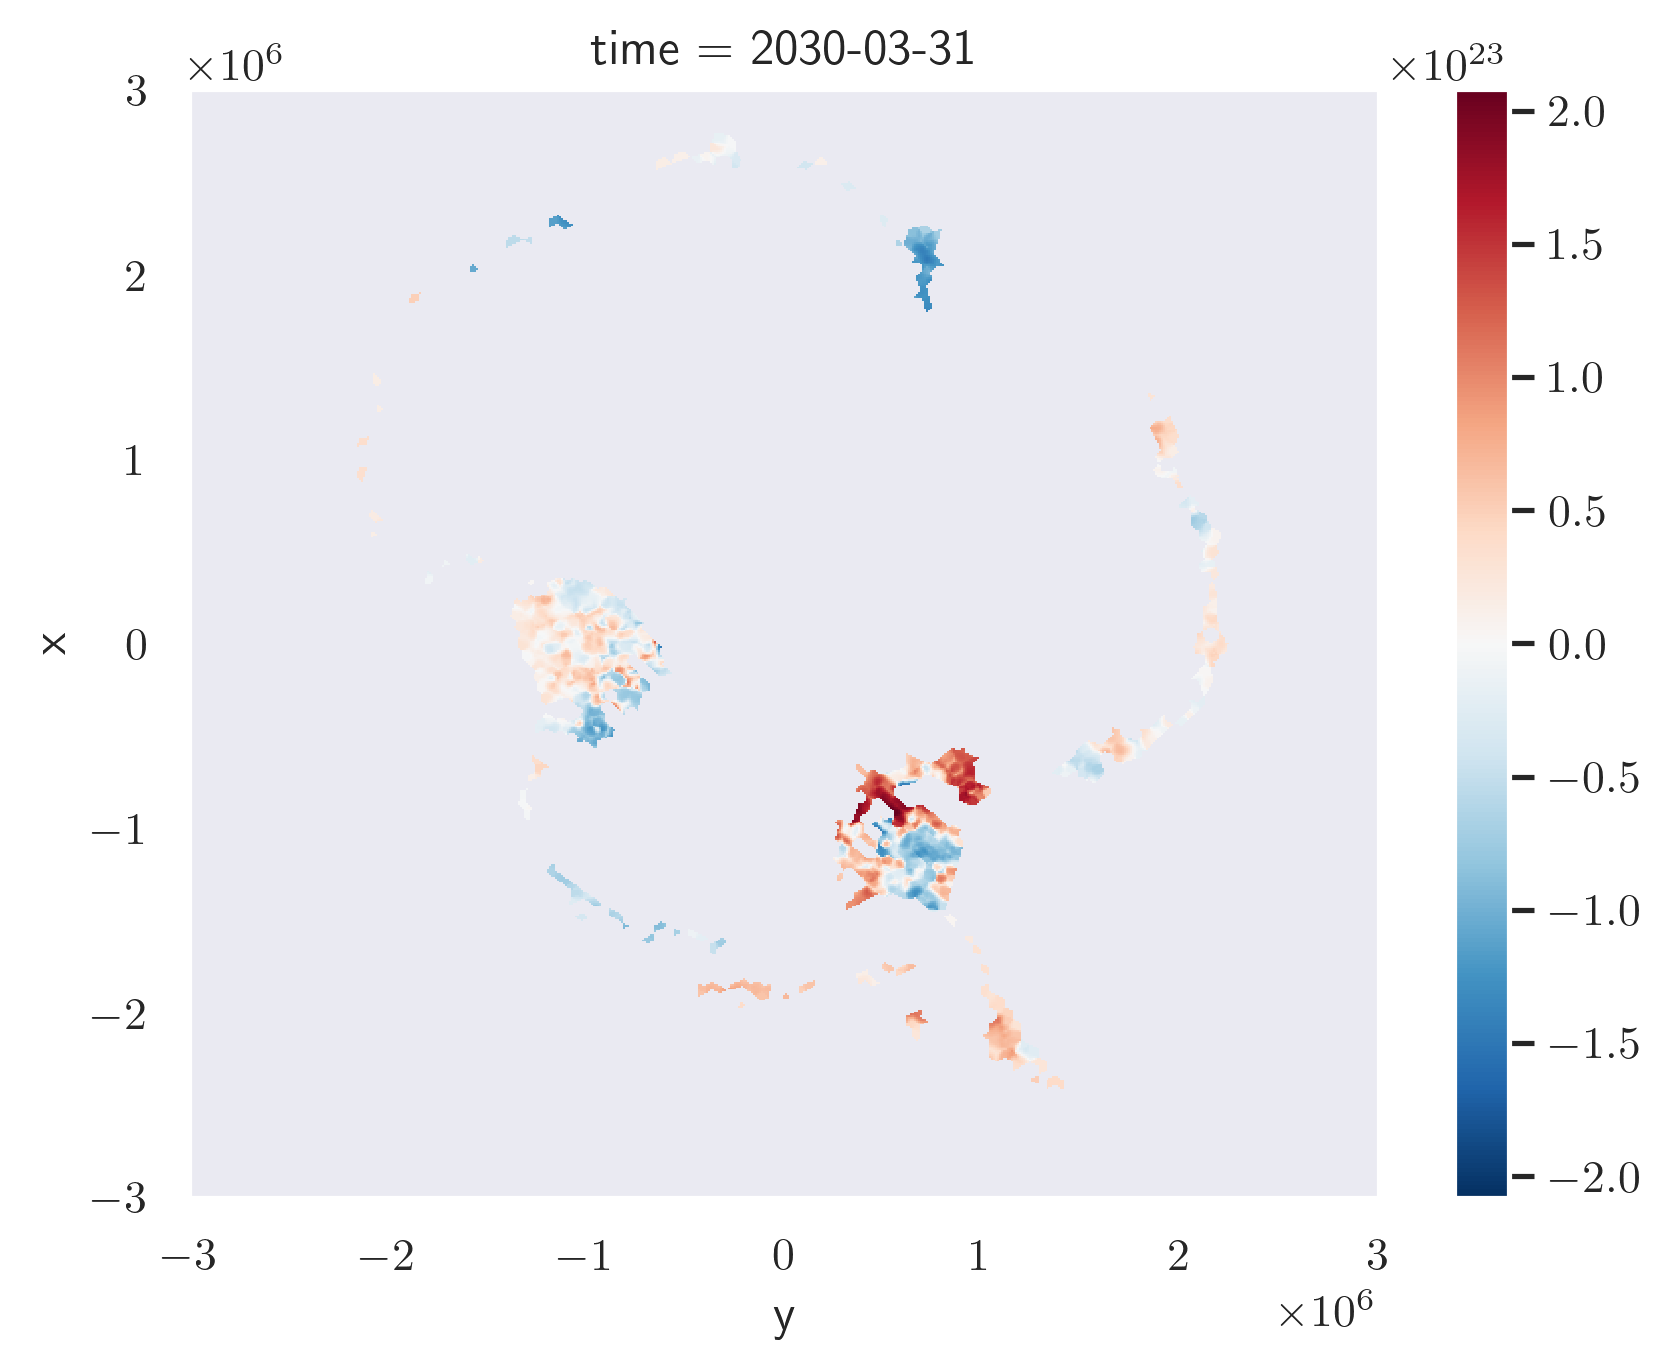

In [47]:
xrec[50].plot()

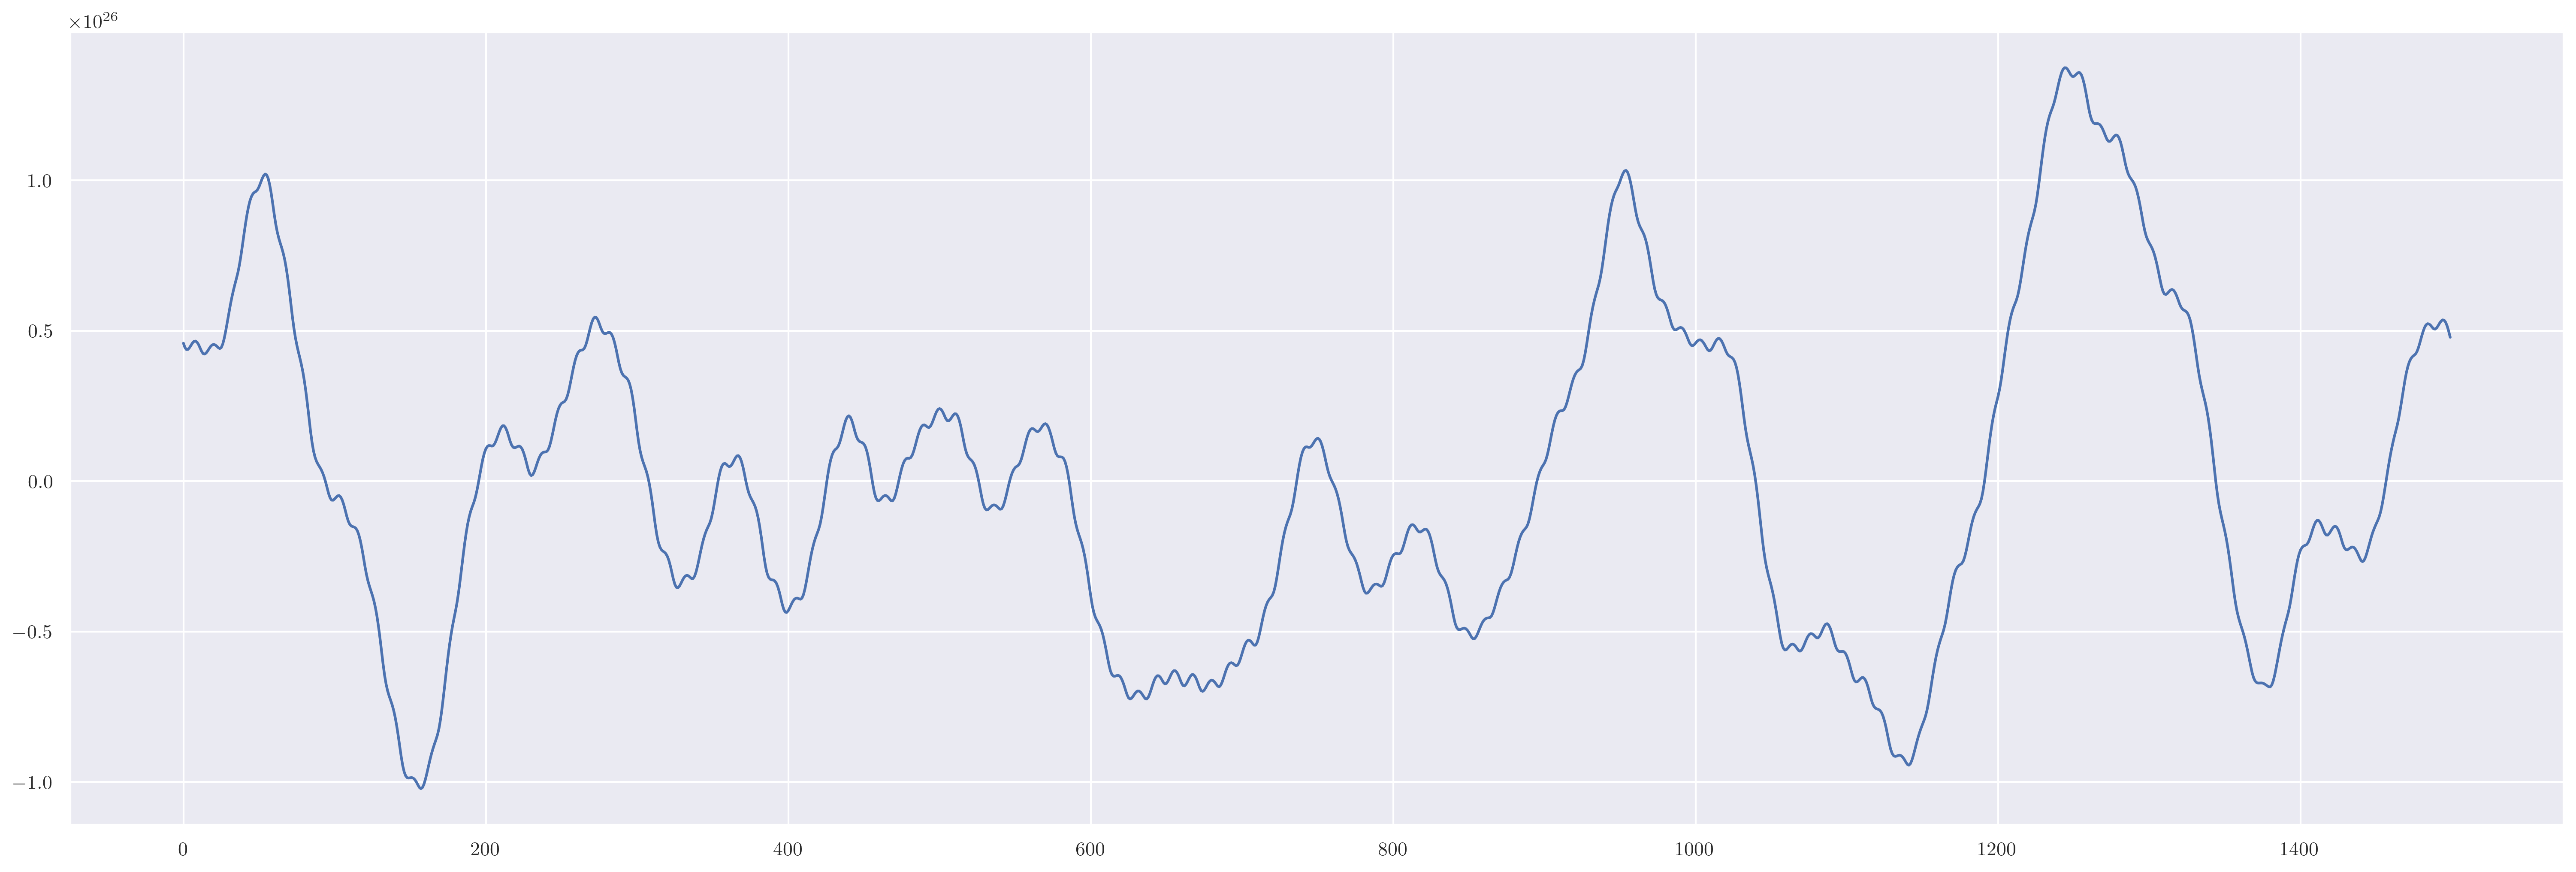

In [42]:
plt.figure(figsize=(25,8))
plt.plot(xrec.sum(['y','x']))

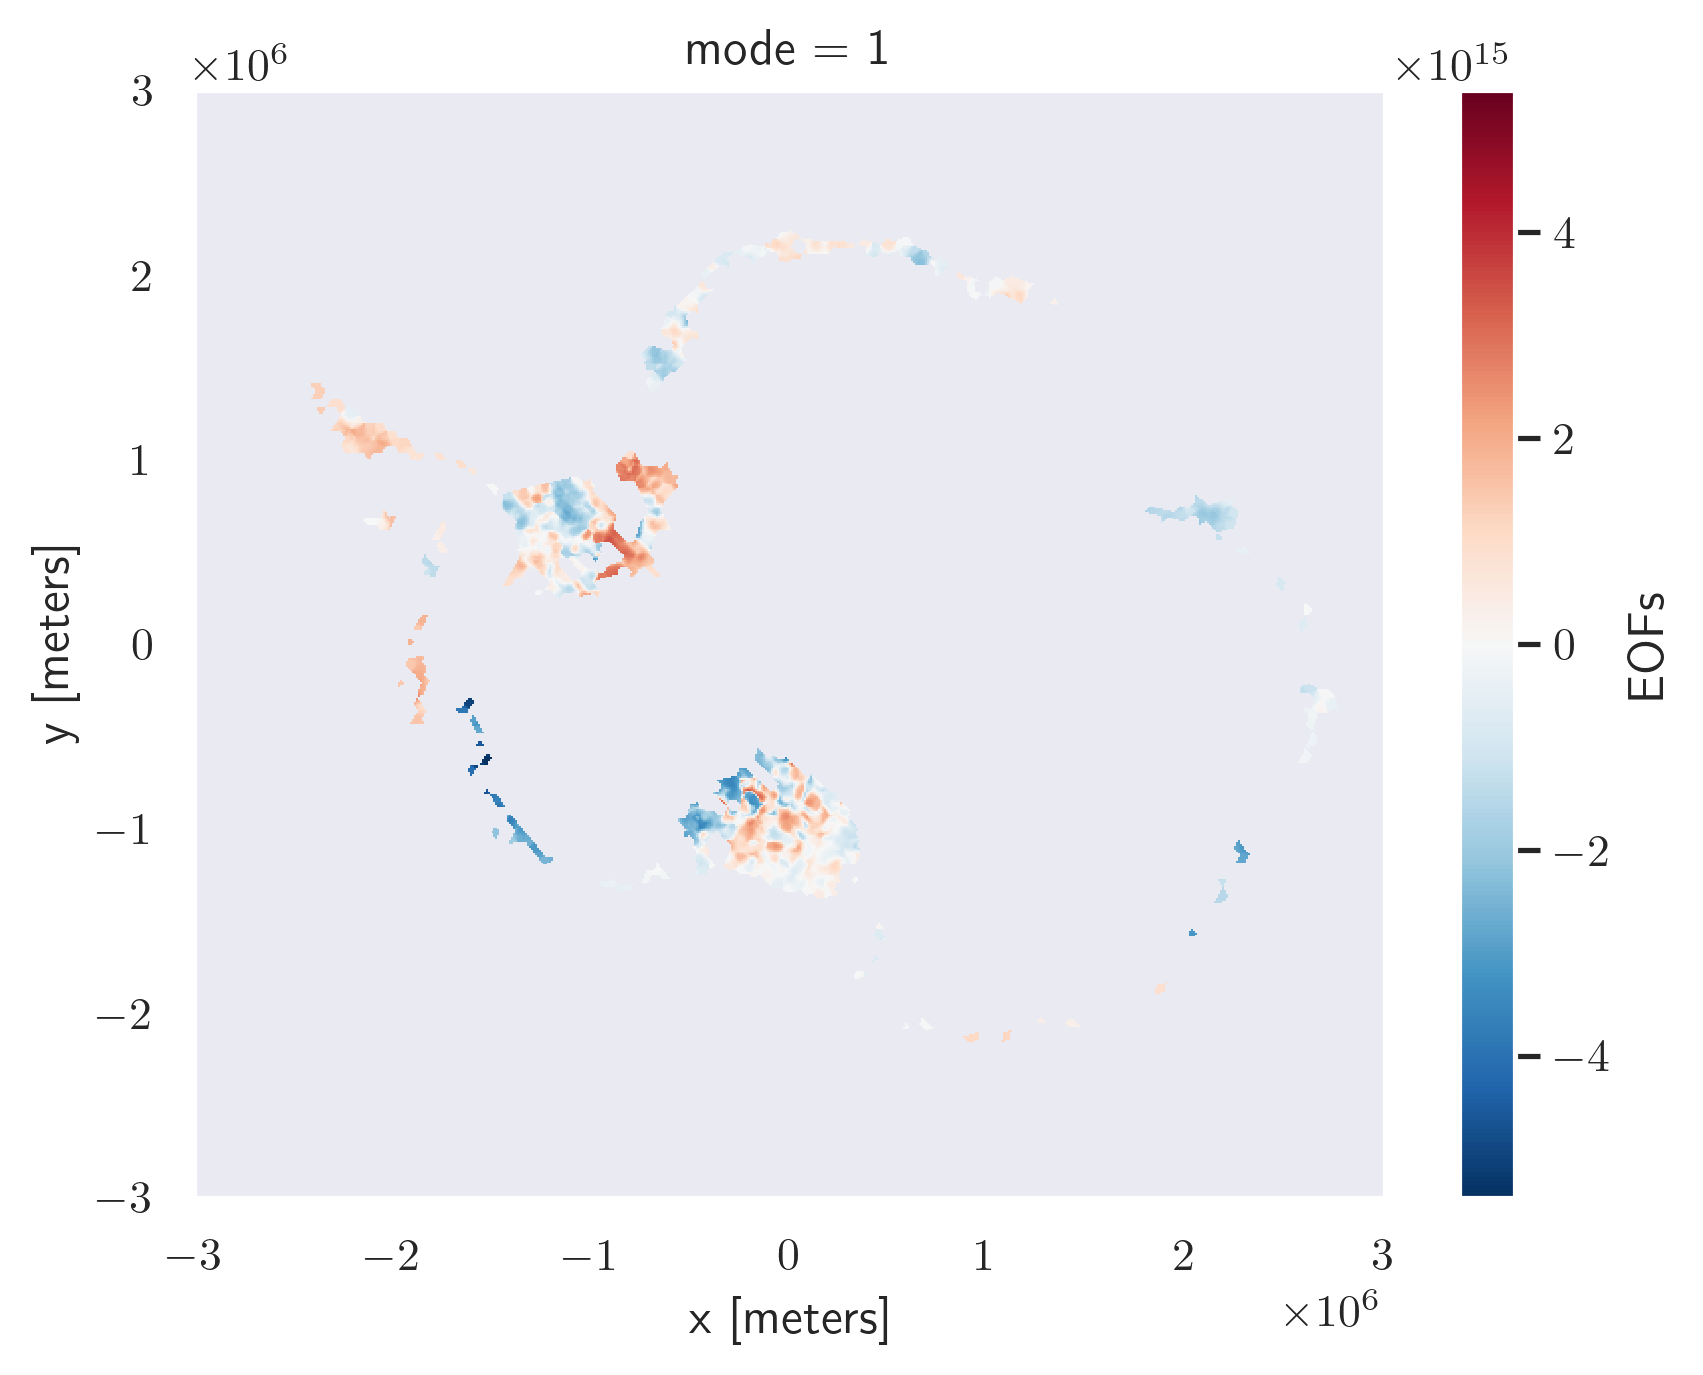

In [22]:
# Sigma definition; Boundary: median/20 --> maximun·10
N = 5 # Number of sigmas to try

m = median(abs(k(:)));    % mean distance
M = max(abs(k(:)));       % maximun distance
sigma = linspace(m/10,M*10,N);

# %% Kernel matrix RBF contruction
K=zeros(nt,nt,N);                           #% Kernel matrix for each sigma
Pc=zeros(nt,h,N);                           #% PC for each sigma
for i=1:N:
    K[:,:,i] = np.exp(-k/(2*sigma[i]**2));         #% kernel function              
    K[:,:,i] = H*K[:,:,i]*H;                    #% Centering Kernel matrix  
    [v,l]=eig(np.squeeze(K[:,:,i]));             
    [~,idx]=sort(diag(l),'descend');          
    v=v(:,idx);                               #% Sort Pcs                      
    v=v(:,1:h);
    Pc(:,:,i)=v;
    clc;
    disp('Building kernel matrix');
    disp('100 %');
    disp('solving Complex RBF');
    disp([num2str(i*100/N),' %']);

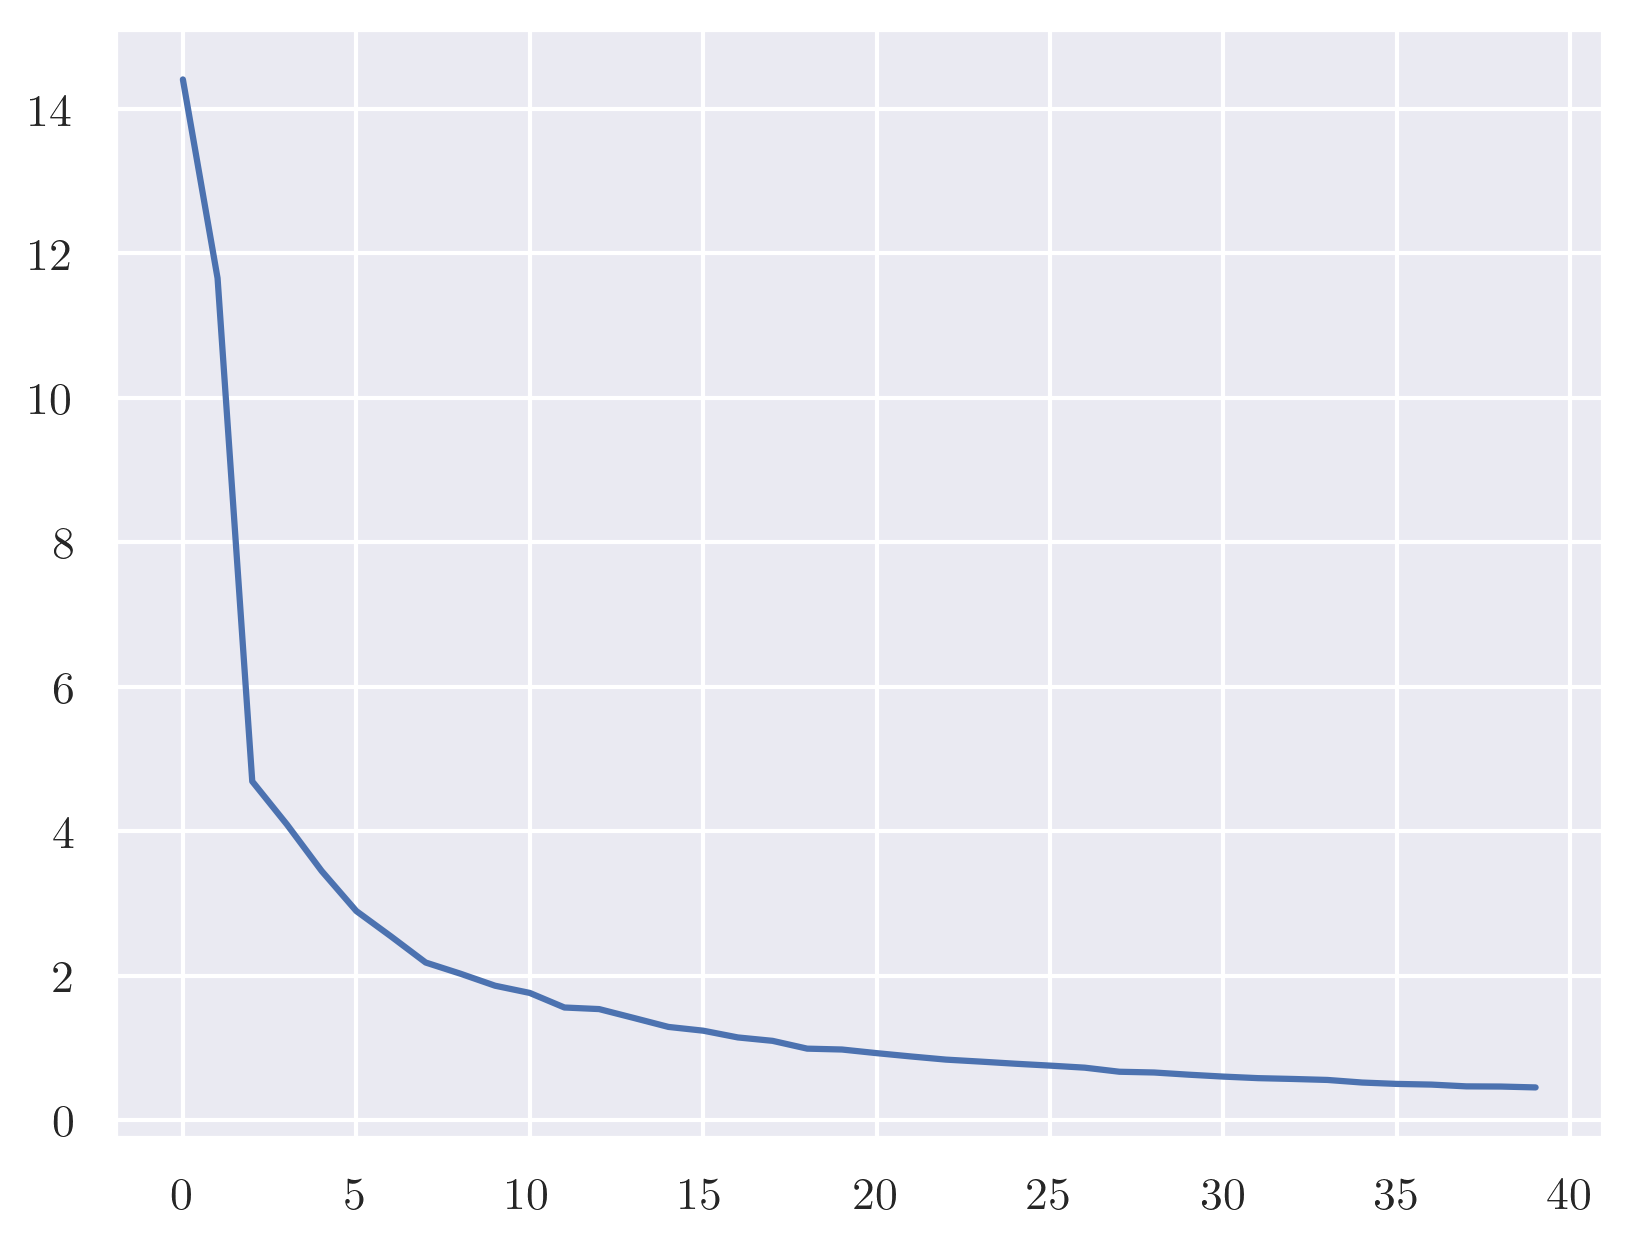

In [18]:
plt.plot(model.lambdas[0:40]*100/sum(model.lambdas))

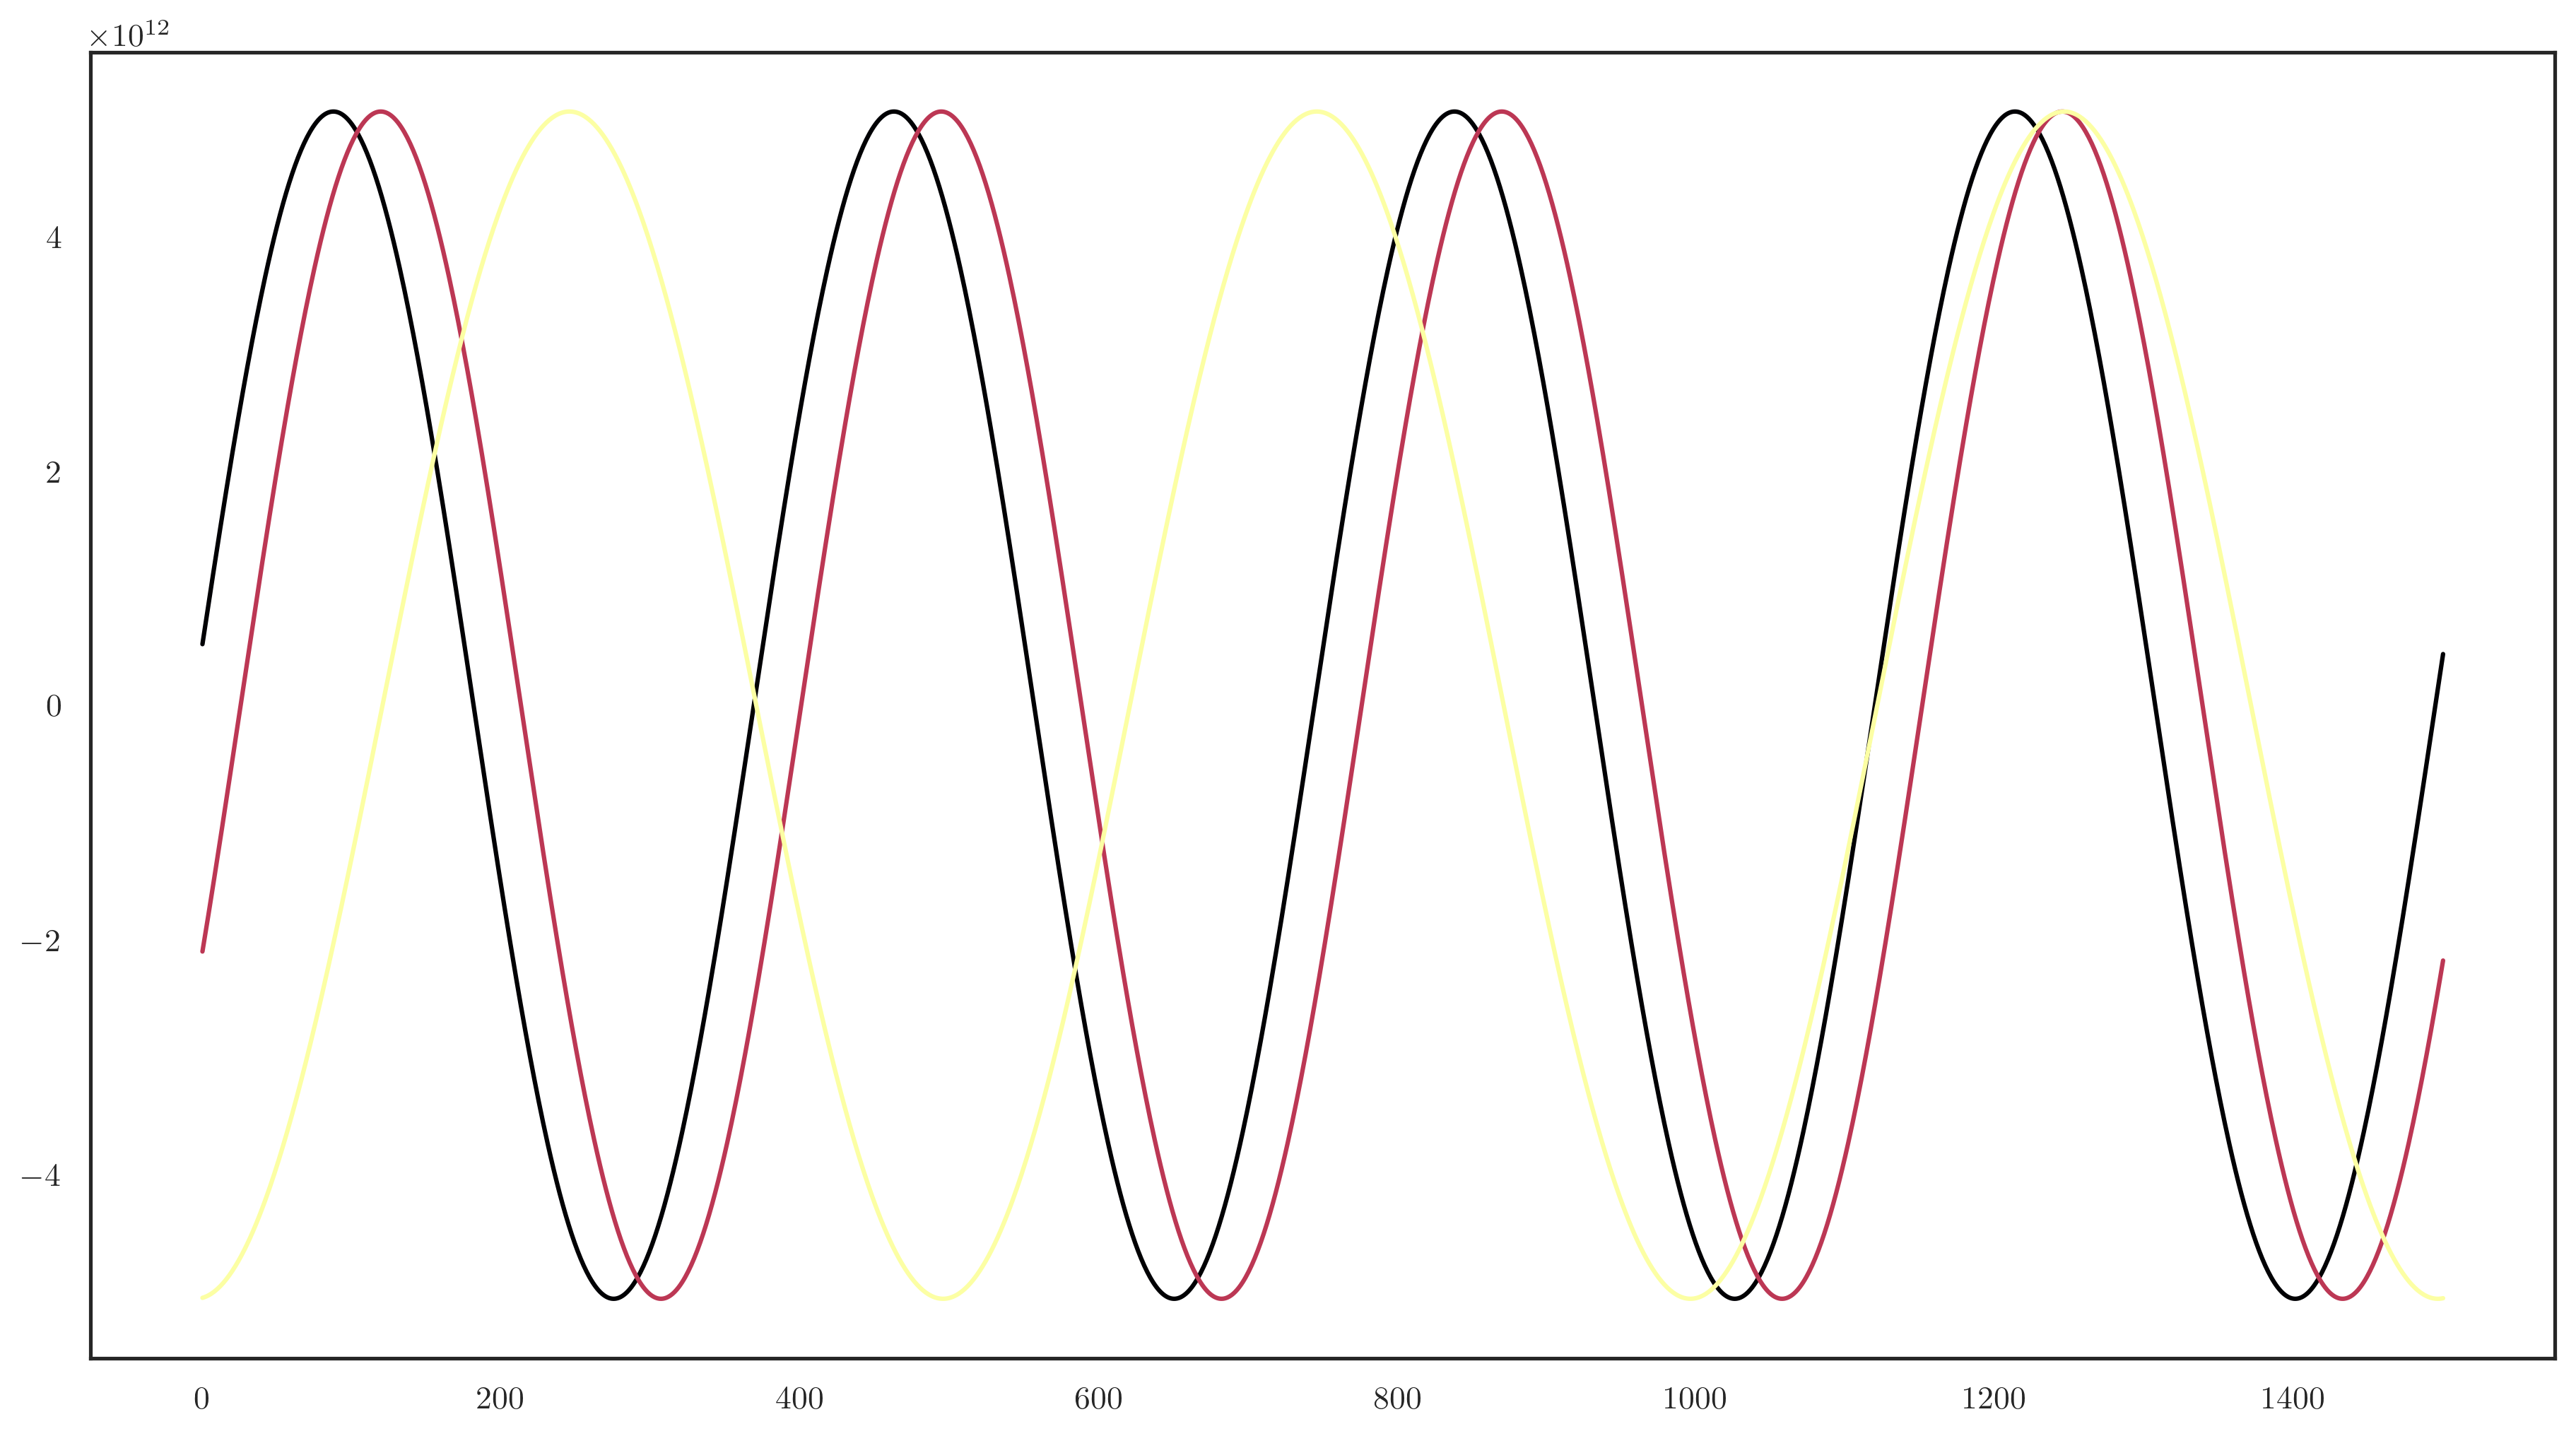

In [42]:
import matplotlib as mpl

ncolors=3
nstart = 0
cmap = mpl.colormaps['inferno'](np.linspace(0,1,ncolors))
plt.figure(figsize=(15,8))

for i in range(nstart,nstart+ncolors):
    plt.plot(pcs[:,i],color=cmap[i])
#plt.legend()

In [ ]:
import matplotlib as mpl
cmap = mpl.colormaps['inferno'](np.linspace(0,1,20))

plt.figure(figsize=(25,8))
for i in range(20):
    pcs[:150,i].plot(lw=2.5, label=i, color=cmap[i])
plt.legend()

#### (5) Complex PCA
This test uses a modified version of the xMCA package for the complex PCA.
`Use model.solve(complexify=True)`

In [ ]:
%%time
model = xMCA(flux_clean_normalized,flux_clean_normalized)
model.solve(complexify=True)

# IF S-mode, i.s., dim='time' (default)
eofs = model.eofs()
pcs = model.pcs()

### Plot relative power of first m modes from the PCA decomposition

In [ ]:
# Figure: Relative power of m EOFs
n_rot = 40
m = n_rot#nmodes
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='black')
plt.ylabel('Relative Power (\%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs: {:.2f}\%'.format(m, varexpl[:m].sum().values*100));

### Plot dominant modes of variability: EOF spatial modes and PC series
The plots show dominant spatial and temporal modes of variability for the normalized dataset. It is difficult to interpret these physically.
#### TODO: Define vmax, vmin params for eofs.plot() if plotting for original cleaned dataset (un-normalized data)

### Plot: (1) Standard EOF without regularization

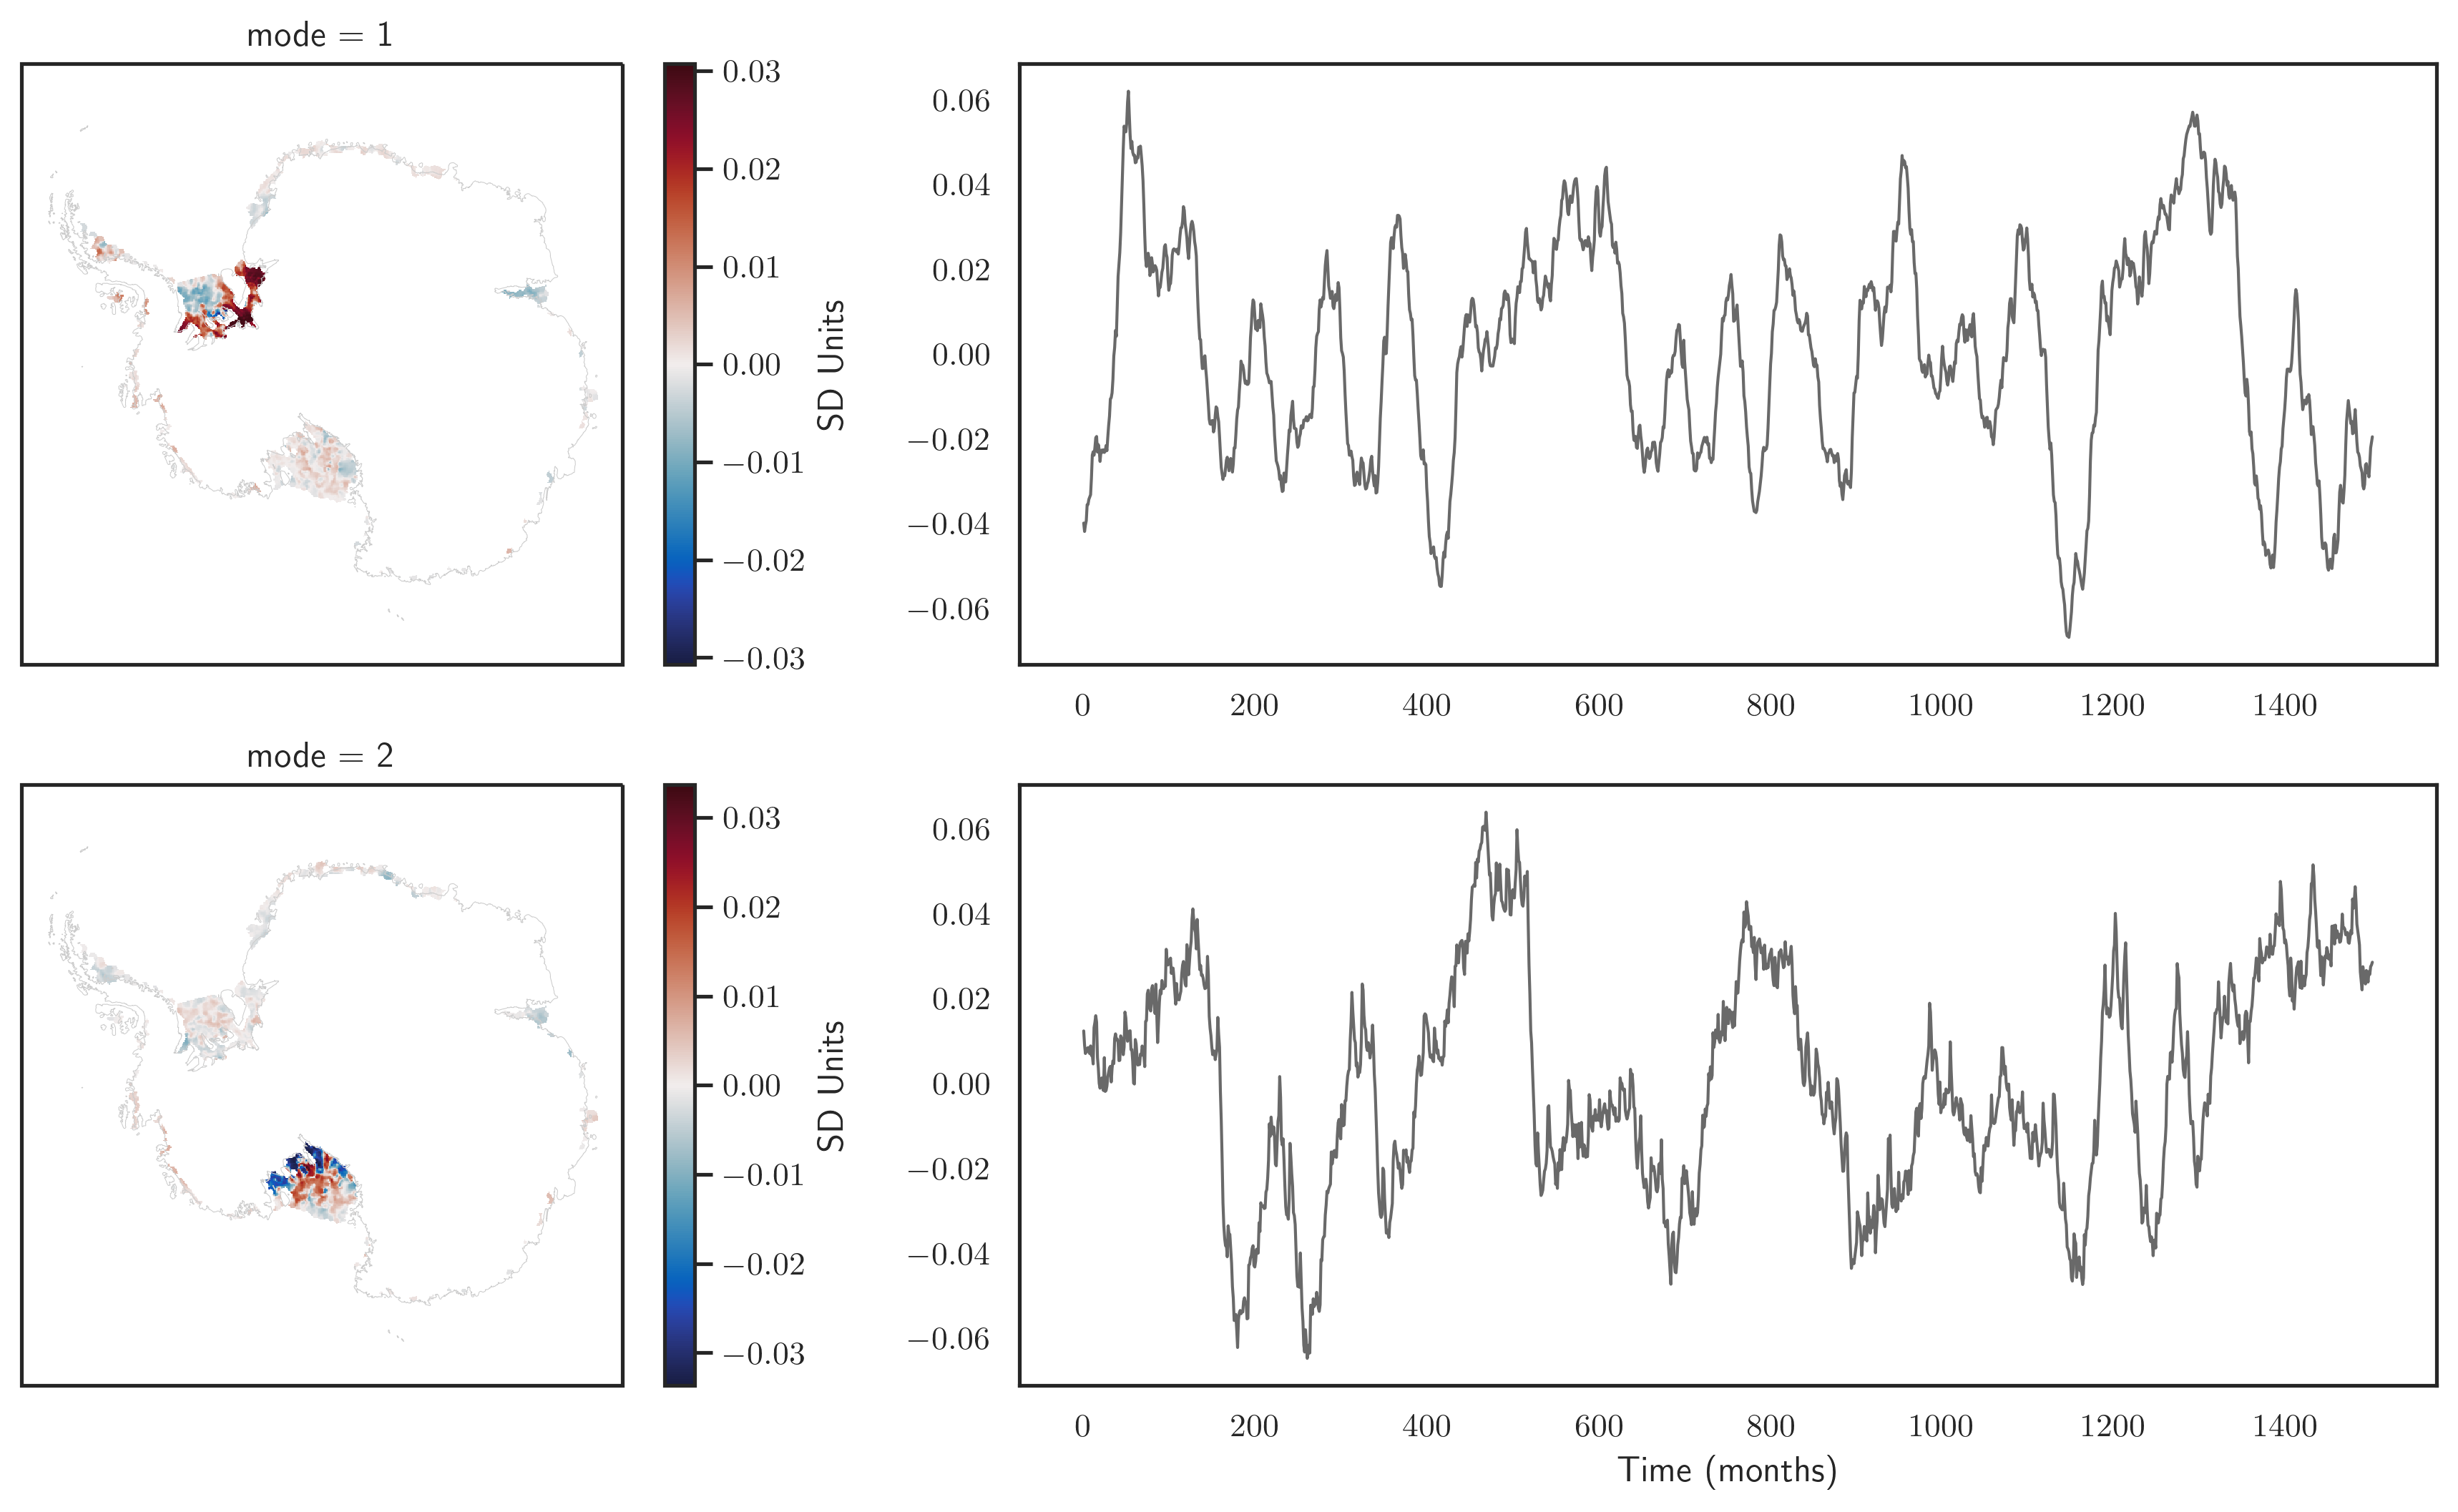

In [30]:
nmodes_plot = 2 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    reofs.sel(mode=i+1).plot(ax=a0,
                               cmap='cmo.balance',
                               add_colorbar=True,
                               cbar_kwargs={'orientation': 'vertical',
                                            'label': 'SD Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(rpcs.sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');
#cb = plt.colorbar(eofs.sel(mode=1), ax=a0, orientation="vertical", pad=0.15)


"""
# Figure: Dominant EOF modes
sns.set_theme(style="white")
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance', # Uses cmocean colorbar - should be installed
                        cbar_kwargs={'orientation': 'vertical',
                                    'label': 'Standard Deviation Units'},
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axs.flatten()];
""";

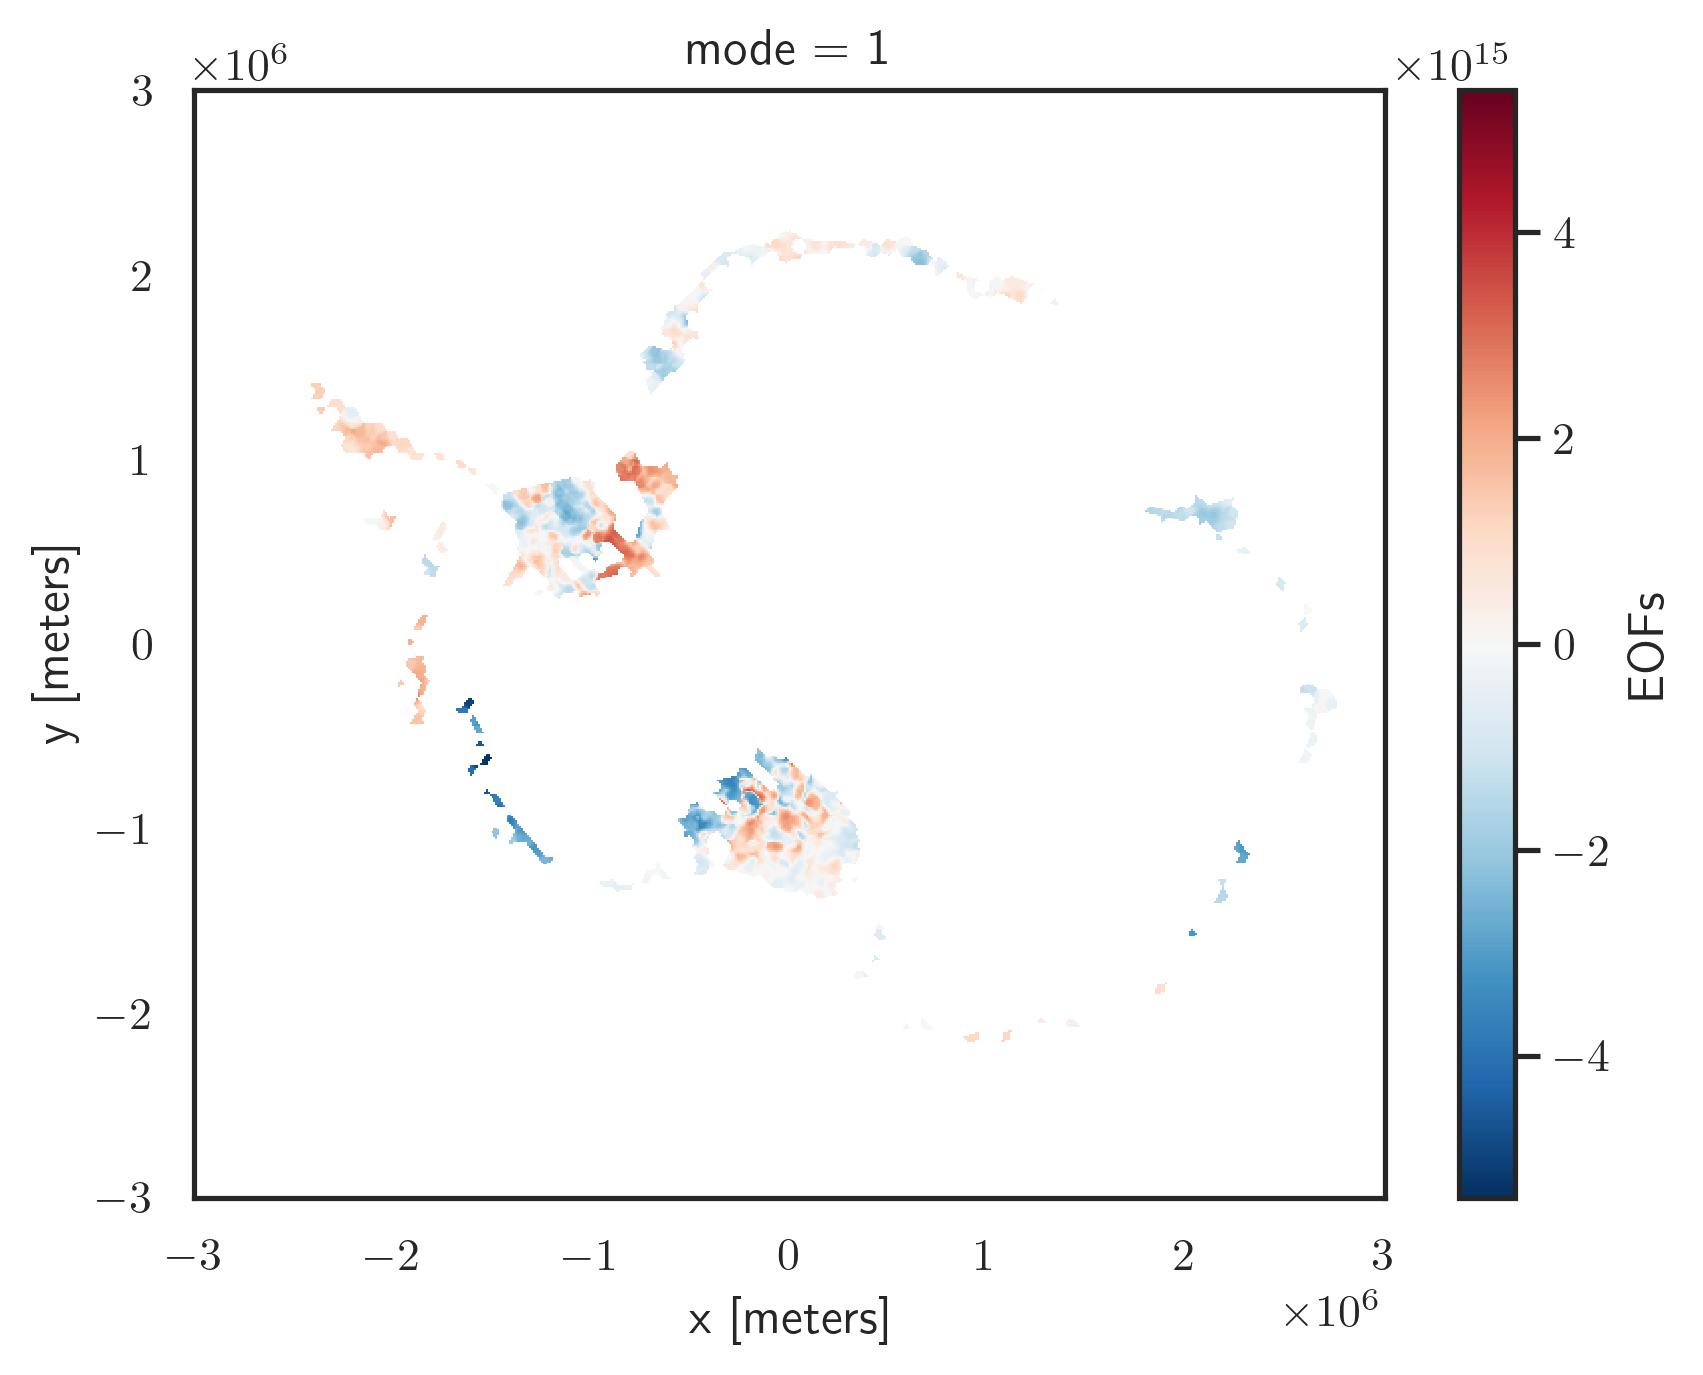

### Plot: (2) Varimax-rotated EOF analysis

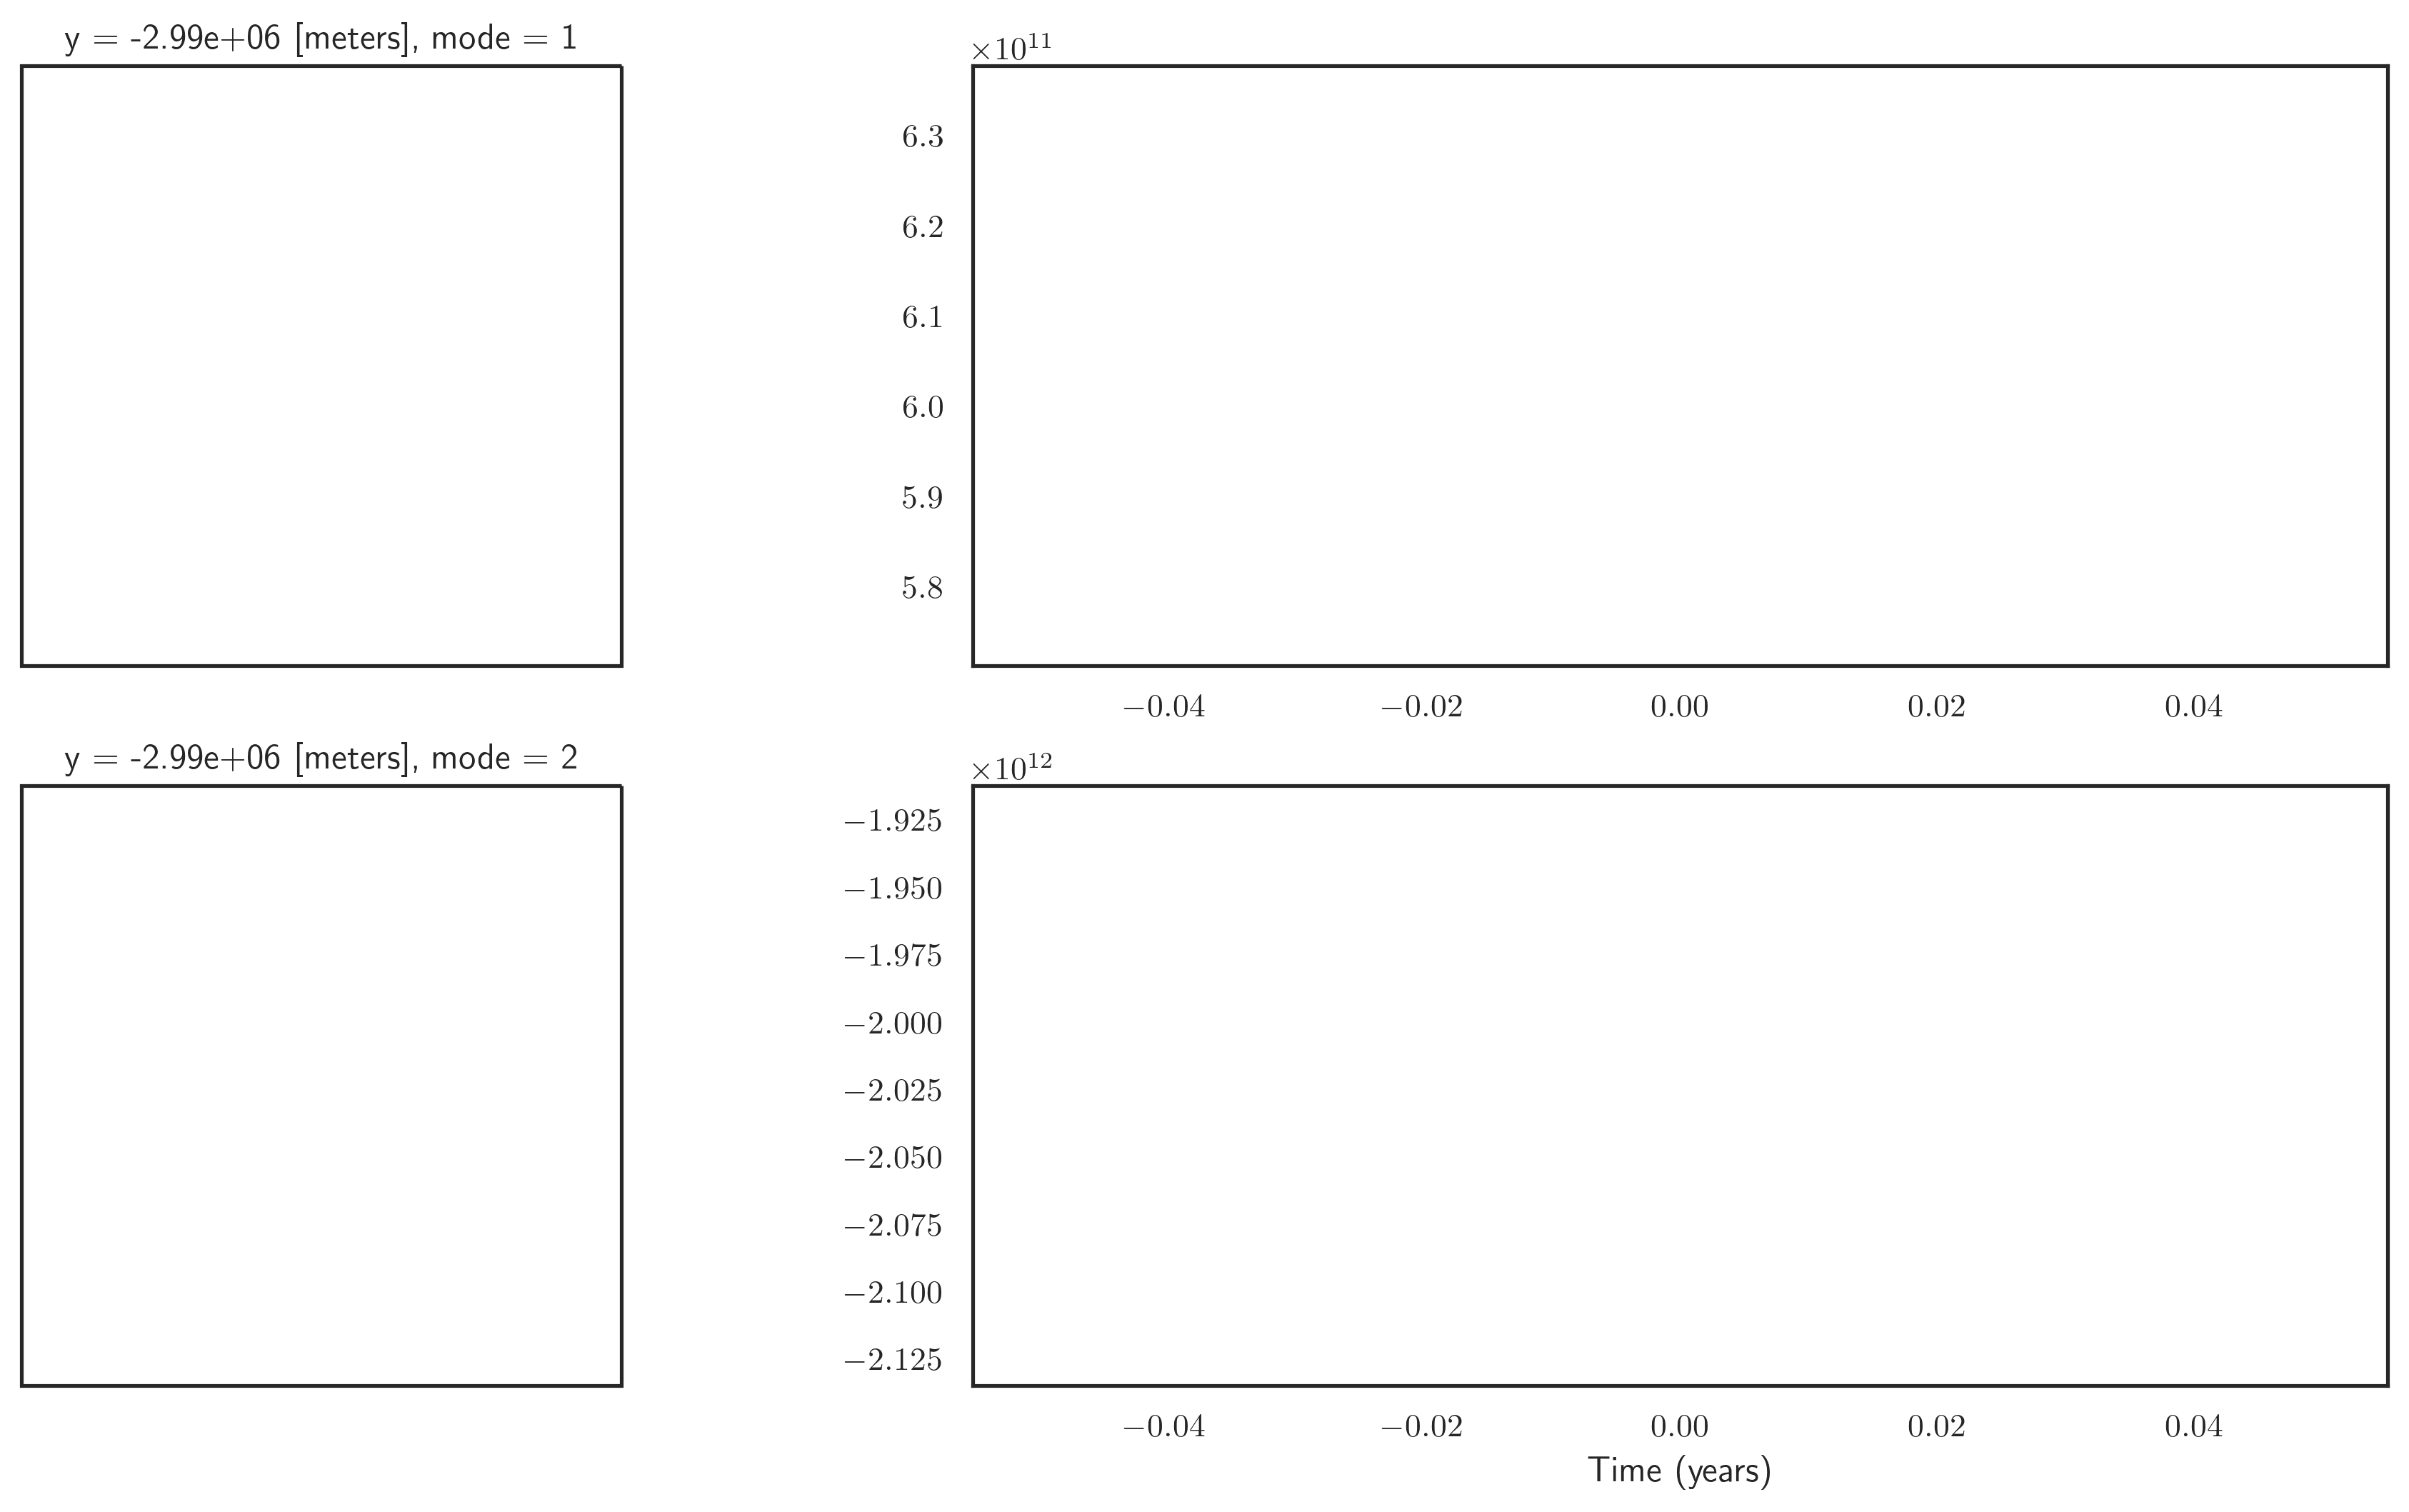

In [26]:
nmodes_plot = 2 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs[1].sel(mode=i+1).plot(ax=a0)
                            #cmap='cmo.balance',
                            #add_colorbar=True,
                            #cbar_kwargs={'orientation': 'vertical',
                            #             'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs[1].sel(mode=i+1),linewidth=1,color='dimgray')
    #a1.set_xticks(np.arange(0,len(pcs[1].time)/12,10))
    a1.set_xlabel('')

a1.set_xlabel('Time (years)');
#cb = plt.colorbar(eofs.sel(mode=1), ax=a0, orientation="vertical", pad=0.15)


"""
# Figure: Dominant EOF modes
sns.set_theme(style="white")
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance', # Uses cmocean colorbar - should be installed
                        cbar_kwargs={'orientation': 'vertical',
                                    'label': 'Standard Deviation Units'},
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axs.flatten()];
""";

### Plot: (3) Promax-rotated EOF analysis

In [ ]:
nmodes_plot = 2 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1.5,2.5])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    eofs[2].sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    a1.plot(pcs[2].sel(mode=i+1),linewidth=1,color='dimgray')
    a1.set_xlabel('')

a1.set_xlabel('Time (months)');
#cb = plt.colorbar(eofs.sel(mode=1), ax=a0, orientation="vertical", pad=0.15)


"""
# Figure: Dominant EOF modes
sns.set_theme(style="white")
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance', # Uses cmocean colorbar - should be installed
                        cbar_kwargs={'orientation': 'vertical',
                                    'label': 'Standard Deviation Units'},
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axs.flatten()];
""";

### Plot: (4) ROCK-PCA analysis

In [31]:
# TODO: Convert amp, phase to reconstructed data
amp = amp
phase = phase
pcs = pcs

In [32]:
pcs_phase = model.pcs_phase()
eofs_phase = model.eofs_phase()
pcs_amp = model.pcs_amplitude()

<xarray.DataArray 'PCs' (time: 1500, mode: 1500)>
array([[ 5.20215116e+11, -2.10096698e+12, -5.05439191e+12, ...,
        -3.60759857e+12, -3.12045541e+12,  1.56250000e-02],
       [ 6.04512126e+11, -2.02350213e+12, -5.05039384e+12, ...,
         4.08773162e+12,  3.66933070e+12,  1.56250000e-02],
       [ 6.88639431e+11, -1.94546923e+12, -5.04559826e+12, ...,
        -4.48016102e+12, -4.13947928e+12,  1.56250000e-02],
       ...,
       [ 2.66542709e+11, -2.32973656e+12, -5.06159534e+12, ...,
         1.75203849e+12,  1.12613098e+12,  1.36718750e-02],
       [ 3.51206686e+11, -2.25410569e+12, -5.05999310e+12, ...,
        -2.42708788e+12, -1.83506632e+12,  1.36718750e-02],
       [ 4.35772068e+11, -2.17784203e+12, -5.05759183e+12, ...,
         3.05006329e+12,  2.50462970e+12,  2.44140625e-03]])
Coordinates:
  * time     (time) datetime64[ns] 2026-01-31 2026-02-28 ... 2150-12-31
  * mode     (mode) int64 1 2 3 4 5 6 7 8 ... 1494 1495 1496 1497 1498 1499 1500

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7190: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


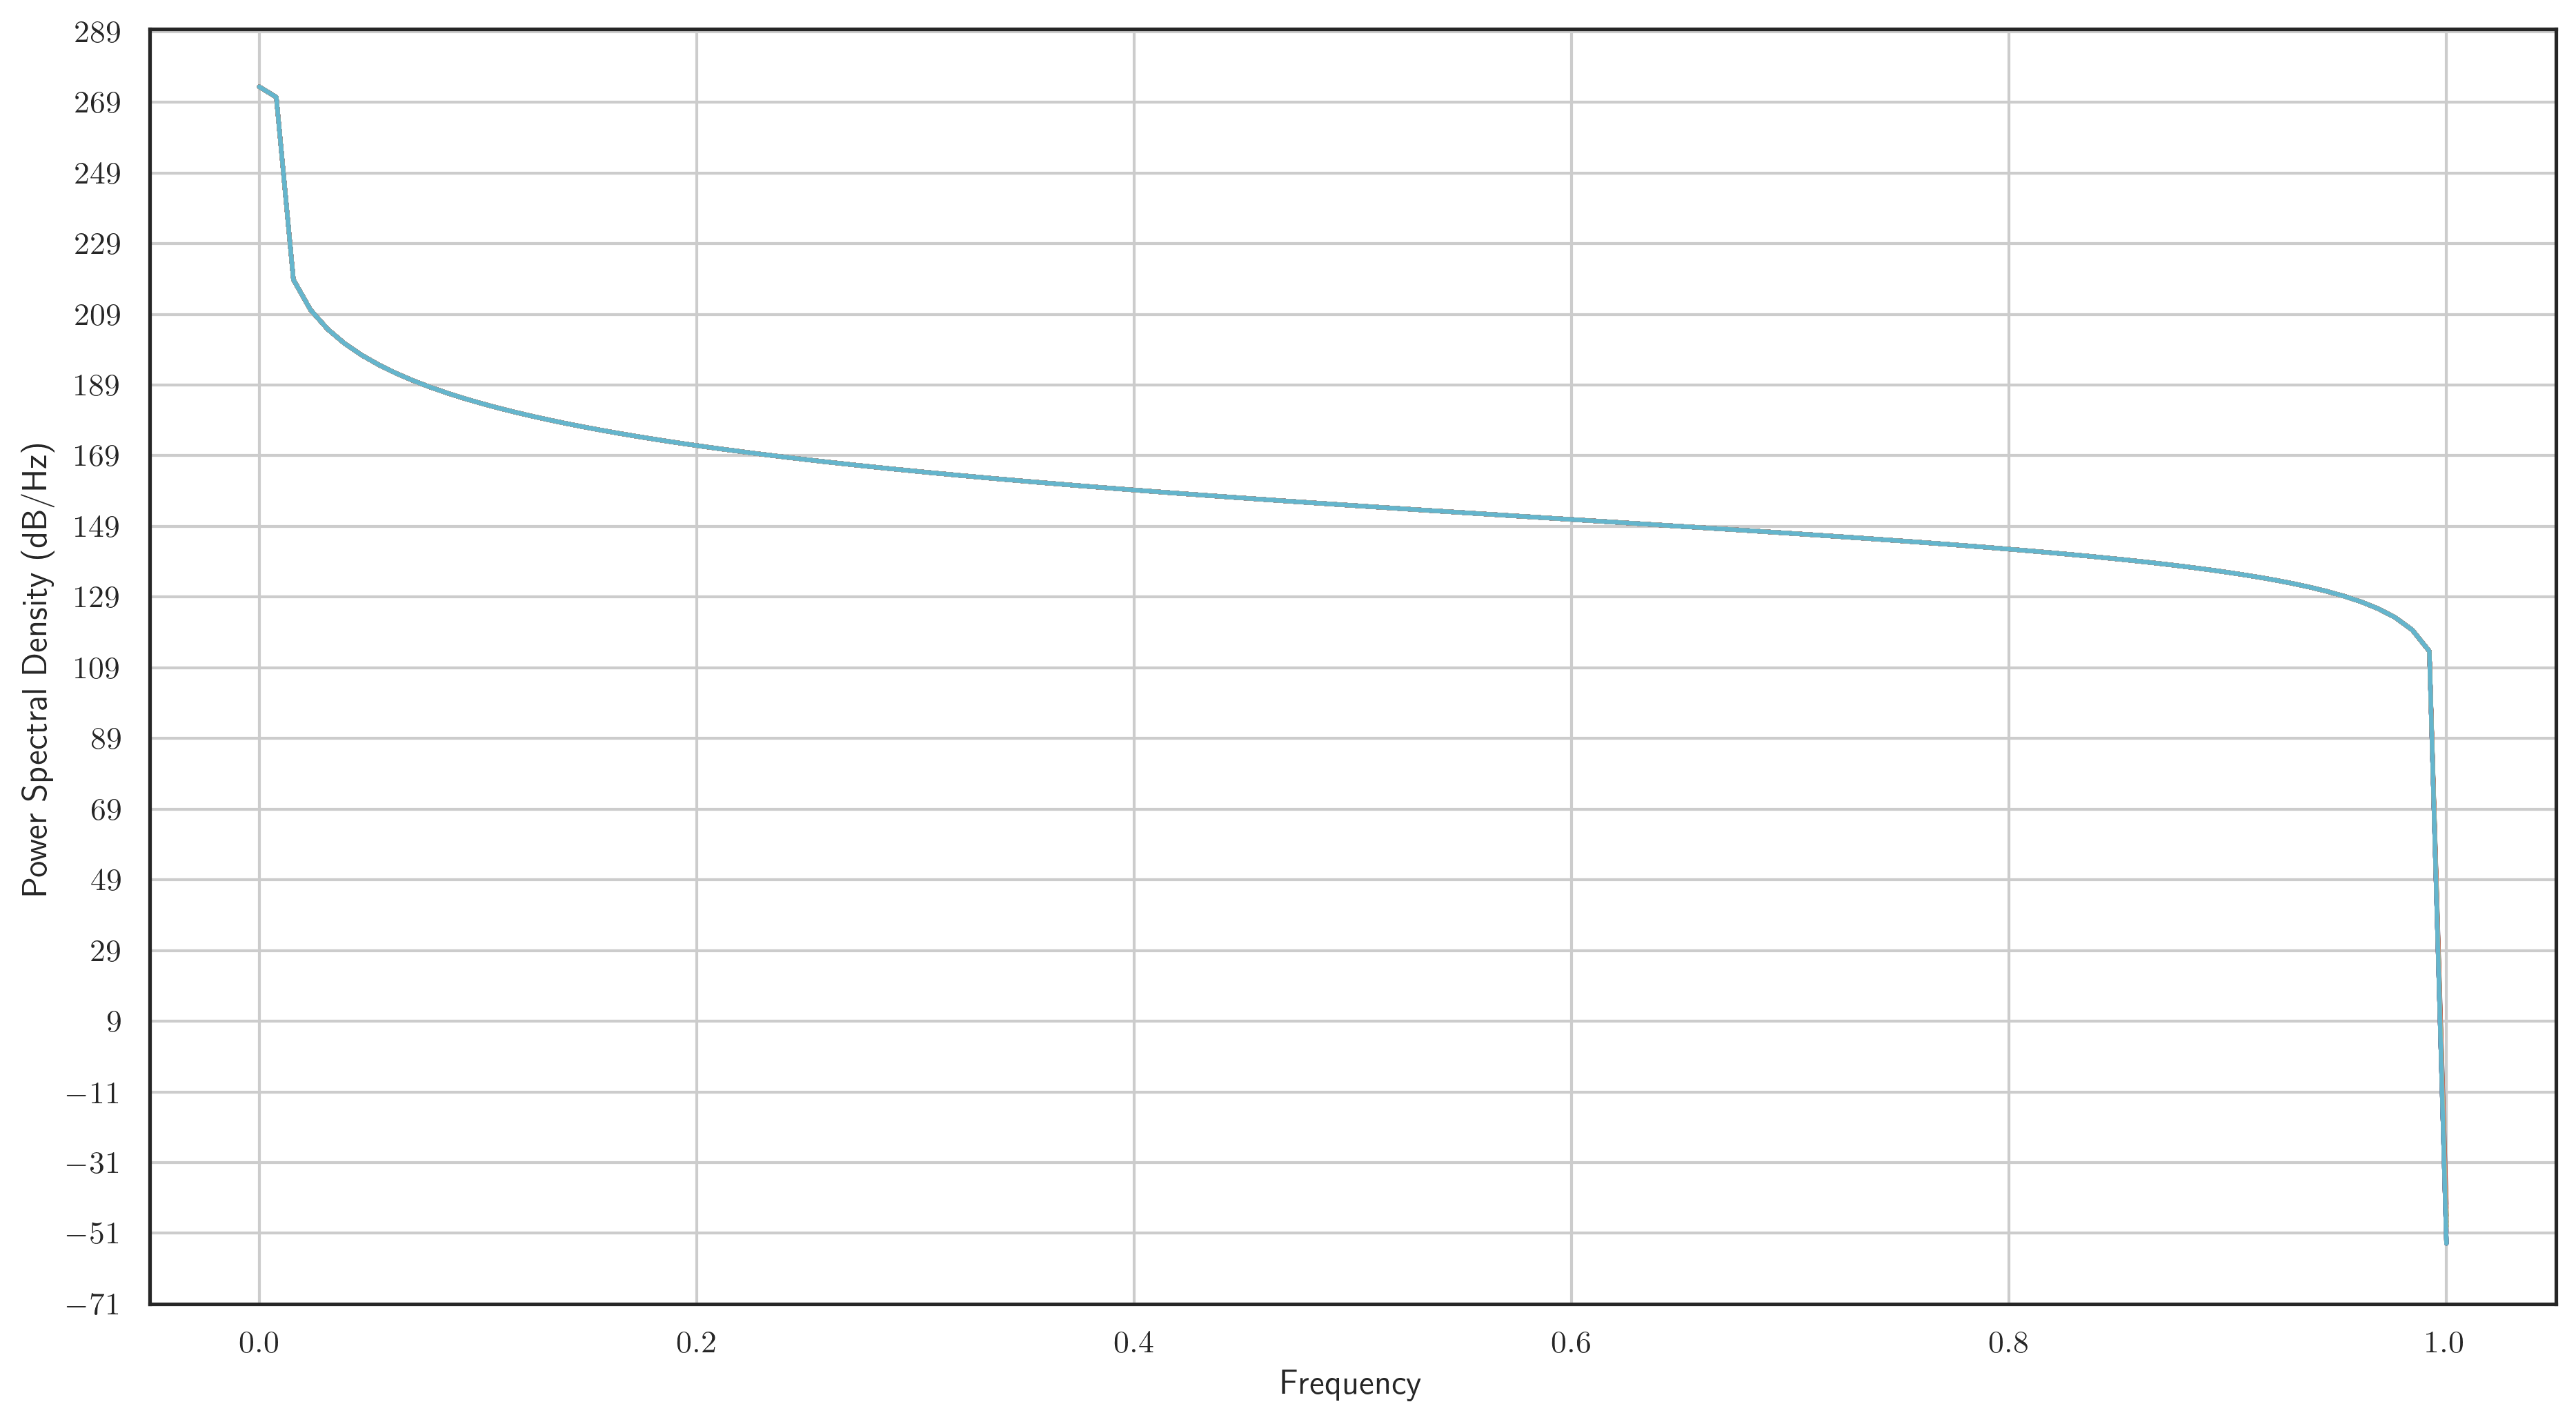

In [38]:
import matplotlib as mpl

ncolors=40
nstart = 0
cmap = mpl.colormaps['inferno'](np.linspace(0,1,ncolors))
plt.figure(figsize=(15,8))

for i in range(nstart,nstart+ncolors):
    #plt.psd(pcs[:,i],noverlap=8,NFFT=256,color=cmap[i-nstart]);
    #pcs.sel(mode=1+i).plot()
    plt.psd(pcs_amp[:,i])
#plt.legend()

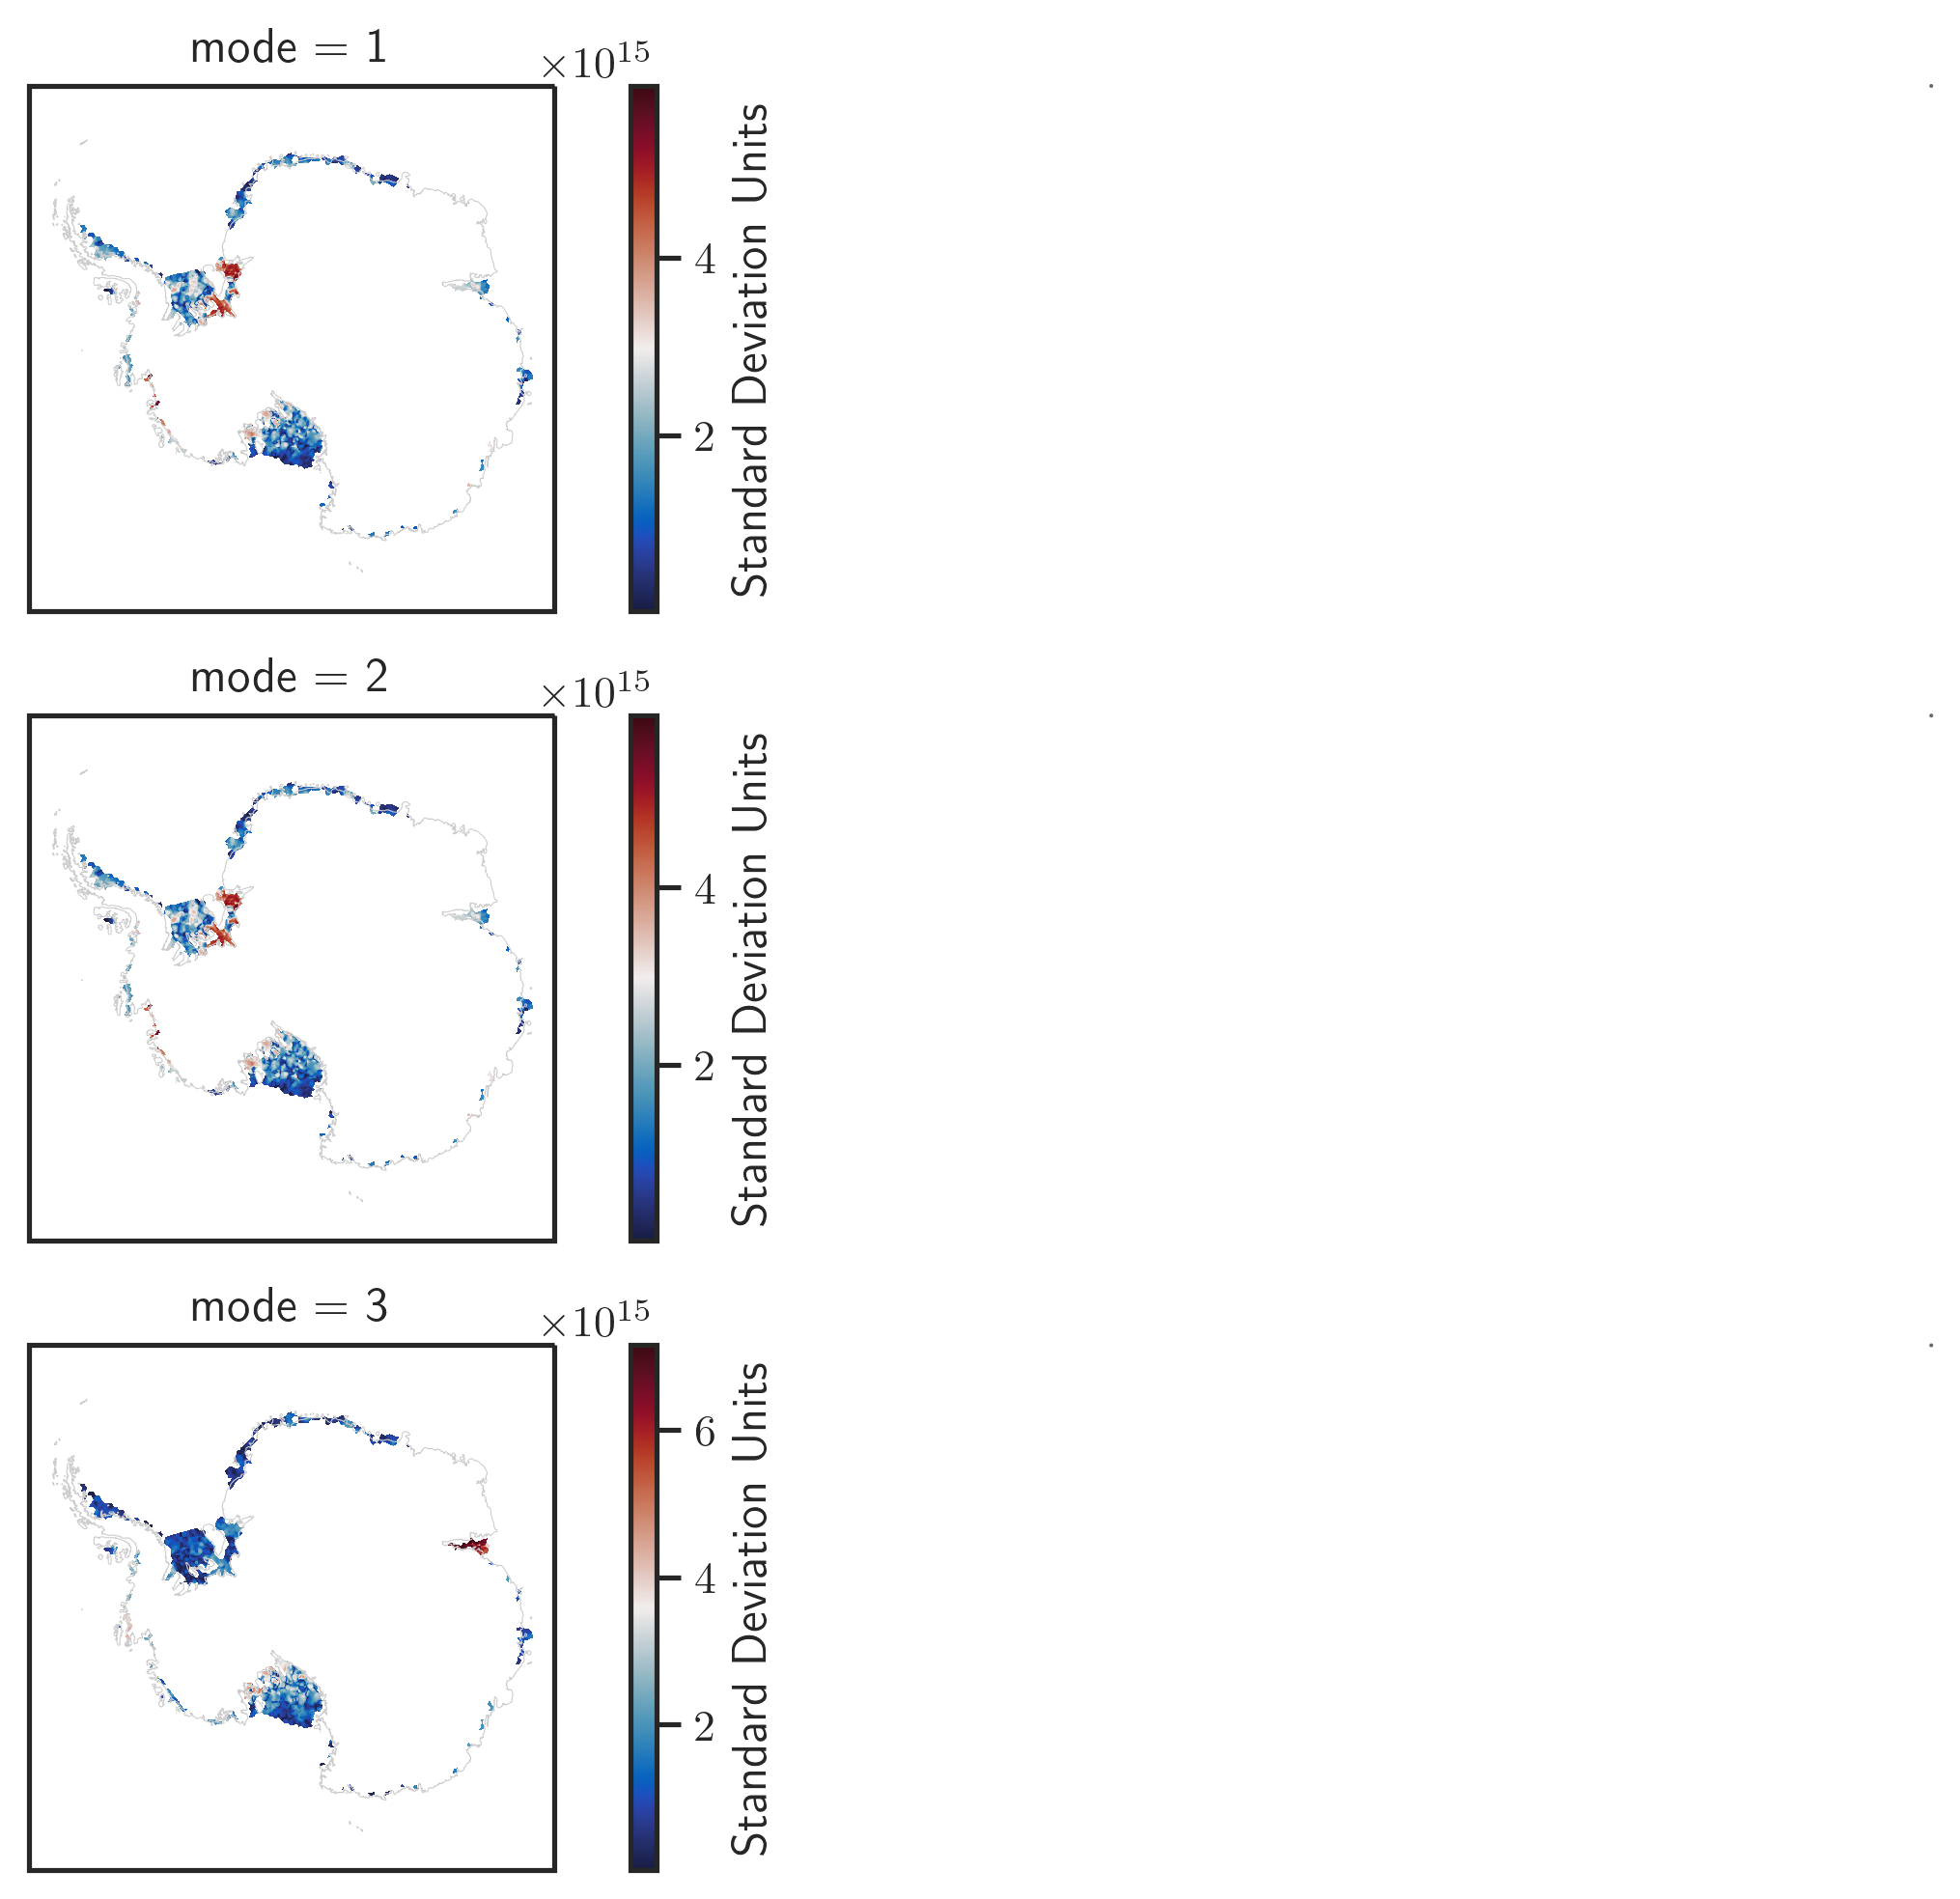

In [35]:
nmodes_plot = 3 # Number of modes to plot

sns.set_theme(style="white")
fig=plt.figure(figsize=(5*nmodes_plot,8))
gs = GridSpec(nmodes_plot,2,width_ratios=[1,1])
ax0 = [fig.add_subplot(gs[i, 0],projection=crs) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1],projection=crs) for i in range(nmodes_plot)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    amp.sel(mode=i+1).plot(ax=a0,
                            cmap='cmo.balance',
                            add_colorbar=True,
                            cbar_kwargs={'orientation': 'vertical',
                                         'label': 'Standard Deviation Units'})
    a0.coastlines(resolution='10m',linewidth=0.25,color='0.8')
    #phase.sel(mode=i+1).plot(ax=a1,
                            #cmap='cmo.balance',
                            #add_colorbar=True,
                            #cbar_kwargs={'orientation': 'vertical',
                            #             'label': 'Standard Deviation Units'})
    a1.plot(pcs_amp.sel(mode=i+1),linewidth=1,color='dimgray')
    
    #a1.set_xlabel('')

a1.set_xlabel('Time (months)');
#cb = plt.colorbar(eofs.sel(mode=1), ax=a0, orientation="vertical", pad=0.15)


"""
# Figure: Dominant EOF modes
sns.set_theme(style="white")
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        cmap='cmo.balance', # Uses cmocean colorbar - should be installed
                        cbar_kwargs={'orientation': 'vertical',
                                    'label': 'Standard Deviation Units'},
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

[ax.coastlines() for ax in fg.axs.flatten()];
""";

Use one of the rotated eofs, pcs as input for the following sections. This can be changed as required.

In [ ]:
# 0 = Standard EOF without regularization
# 1 = Varimax-rotated EOF - This yields a sparse representation
# 2 = Promax-rotated EOF
eofs = eofs[1]
pcs = pcs[1]

## Fourier Phase Randomization

Now, the projection co-efficients from the previous step are phase-randomized to generate new realizations of the data. In this step, we sample phases for each FFT(PC) from (0,$2\pi$), and iterate to generate n realizations.

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 2
t_length = pcs.shape[0]

# Define random number generator 
#rng = np.random.default_rng(2021)
#random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j) in line 26

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(pcs.shape[1]):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        #random_phases = np.exp(np.random.default_rng(2023).uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
    print('calculated ifft for realization {}, all modes'.format(i))

In [ ]:
nmodes_plot = 3 # Number of modes to plot
nrealizations_to_plot = n_realizations # to be lesser than absolute total number, defined in the Fourier randomization step

sns.set_theme(style="white")
fig=plt.figure(figsize=(25,20))

gs = GridSpec(nmodes_plot, 2, width_ratios=[4, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(nmodes_plot)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(nmodes_plot)]

for i, (a0,a1) in enumerate(zip(ax0,ax1)):
    for n_realization in range(0,nrealizations_to_plot):
        a0.plot(new_fl[n_realization,:,i],color='b', linewidth=0.5)
        a1.psd(new_fl[n_realization,:,i],color='b', linewidth=0.5)
    a0.plot(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a1.psd(new_fl[0,:,i],color='b', linewidth=0.25,label='Randomized')
    a0.plot(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a1.psd(pcs[:,i],color='k', linewidth=2.5,label='Original')
    a0.set_title('PC for EOF mode {}'.format(i+1))
    a1.set_title('PSD for PC mode {}'.format(i+1))
    a1.set_xlabel('')

a0.set_xlabel('Time (months)')
a1.set_xlabel('Frequency')
plt.legend();

## Helper Functions

Functions defined for the generation and follow on calculations

In [ ]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

def rmse_calc(rec_data,orig_data):
        rmse = mean_squared_error(10*np.log10(rec_data),10*np.log10(orig_data),squared=False)
        return rmse

# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Statistical Generation

This uses a custom function presently committed to the `xeofs` package. There is the possibility that this might break should `xeofs` be upgraded.

*Ref: For commit diff details, see [mshiv/xeofs-rand](https://github.com/nicrie/xeofs/compare/main...mshiv:xeofs-rand:main).*
#### TODO: Rewrite generator function using PCA as a standalone package and remove `xeofs` dependency.

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, nmodes, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+temp_rotated_path+"REC_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

### (1) Statistical Generation of Residuals

No normalization necessary to be applied, the reconstruction does not require to be "unnormalized".

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, nmodes, 1)
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+temp_rotated_path+"REC_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

## Input generated dataset files

Versions of these files from different experimental runs are currently housed in the project repo at ```/data/interim```. Note that the ```/data``` directory is ignored for remote commits, and is currently available only on local.
Location can be changed above when saving the file to NETCDF in the Generation step.

In [ ]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+temp_rotated_path+'REC_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+temp_rotated_path+'REC_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

In [ ]:
flux_reconstr0 = flux_reconstr0 + proj0*xh0
flux_reconstr1 = flux_reconstr1 + proj0*xh0

In [ ]:
resids_m_per_yr.to_netcdf(inDirName+interim_data_folder+
                          cise_file_path+std_file_path+temp_rotated_path+"residual_input.nc")

In [ ]:
# Specify catchments to clip data and plot for comparisons
#Old reconstructions: 
# basins = np.array((34,55,114,103,104,105))
# From previous section on chosen catchments (Scatter plot):
catchments = np.array([1,27,28,61,70,83,94,71,22])
basins = catchments+33

# Sample ice shelves chosen:
# Amery = 1 ~ 34
# George VI = 27 ~ 
# Getz = 28
# Pine Island = 61
# Ronne = 70
# Totten = 83
# Wilkins = 94
# Western Ross = 71
# Filchner = 22
# Thwaites = 81
# Eastern_Ross = 72

Create subsets of data (original and reconstructed realizations) for individual catchments. The data variables in each are named so that they may be easily input using the `xarray.open_mfdataset` method. Note however that `CDO` terminal commands are better suited for this if the number of realizations is significantly high (beyond 30?)

In [ ]:
"""
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    rec3 = clip_data(flux_reconstr3, basin)
    rec4 = clip_data(flux_reconstr4, basin)
    orig.rename('orig_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"orig_{}.nc".format(basin))
    rec0.rename('rec0_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"rec0_{}.nc".format(basin))
    rec1.rename('rec1_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"rec1_{}.nc".format(basin))
    rec2.rename('rec2_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"rec2_{}.nc".format(basin))
    rec3.rename('rec3_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"rec3_{}.nc".format(basin))
    rec4.rename('rec4_{}'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+"rec4_{}.nc".format(basin))
    del orig, rec0, rec1, rec2, rec3, rec4
    gc.collect()
"""

#### Clip data to each basin

In [ ]:
%%time
for basin in basins:
    #orig = clip_data(flux_clean, basin)
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    orig.rename('orig'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_rotated_path+"orig_{}.nc".format(basin))
    rec0.rename('rec0'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_rotated_path+"rec0_{}.nc".format(basin))
    rec1.rename('rec1'.format(basin)).to_netcdf(inDirName+interim_data_folder+
                                                   cise_file_path+std_file_path+temp_rotated_path+"rec1_{}.nc".format(basin))
    del orig, rec0, rec1
    gc.collect()

In [ ]:
%%time
for basin in basins:
    orig = xr.open_dataset(inDirName+interim_data_folder+
                           cise_file_path+std_file_path+temp_rotated_path+"orig_{}.nc".format(basin))
    rec0 = xr.open_dataset(inDirName+interim_data_folder+
                           cise_file_path+std_file_path+temp_rotated_path+"rec0_{}.nc".format(basin))
    rec1 = xr.open_dataset(inDirName+interim_data_folder+
                           cise_file_path+std_file_path+temp_rotated_path+"rec1_{}.nc".format(basin))

In [ ]:
catchments = np.array([1,27,28,61,70,83,94,71,22])
basins = catchments+33
basins

In [ ]:
basin=55
orig = xr.open_dataset(inDirName+interim_data_folder+
                       cise_file_path+std_file_path+temp_rotated_path+"orig_{}.nc".format(basin))
rec0 = xr.open_dataset(inDirName+interim_data_folder+
                       cise_file_path+std_file_path+temp_rotated_path+"rec0_{}.nc".format(basin))
rec1 = xr.open_dataset(inDirName+interim_data_folder+
                       cise_file_path+std_file_path+temp_rotated_path+"rec1_{}.nc".format(basin))

orig_ts = time_series(orig.orig)
rec0_ts = time_series(rec0.rec0)
rec1_ts = time_series(rec1.rec1)

In [ ]:
plt.plot(orig_ts);
plt.plot(rec0_ts);
plt.plot(rec1_ts);

In [ ]:
plt.psd(orig_ts);
plt.psd(rec0_ts);
plt.psd(rec1_ts);

#### Combiine realizations and original data as separate data variables in `NETCDF` files.

In [ ]:
for basin in basins:
    basin_combined_datasets = xr.open_mfdataset(inDirName+interim_data_folder+
                                                cise_file_path+std_file_path+temp_rotated_path+"*_{}.nc".format(basin),
                                                combine='nested')
    basin_combined_datasets.to_netcdf(inDirName+interim_data_folder+
                                      cise_file_path+std_file_path+temp_rotated_path+"combined_{}.nc".format(basin))
    del basin_combined_datasets
    gc.collect()

In [ ]:
for basin in basins:
    basin_combined_datasets = xr.open_mfdataset(inDirName+interim_data_folder+
                                                cise_file_path+std_file_path+temp_rotated_path+"*_{}.nc".format(basin))
    basin_combined_datasets.to_netcdf(inDirName+interim_data_folder+
                                      cise_file_path+std_file_path+temp_rotated_path+"combined_{}.nc".format(basin))
    del basin_combined_datasets
    gc.collect()

#### Plot figure (time series and PSD comparisons for each basin)

In [ ]:
n_basins = len(basins)

color_orig = 'k'
color_gen = 'dimgray'

sns.set_theme(style="white")
fig=plt.figure(figsize=(18,5*n_basins))

gs = GridSpec(n_basins, 2, width_ratios=[3, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(n_basins)]
ax1 = [fig.add_subplot(gs[i, 1]) for i in range(n_basins)]

for i,(a0,a1) in enumerate(zip(ax0,ax1)):
    combined_ds = xr.open_dataset(inDirName+interim_data_folder+
                              cise_file_path+std_file_path+temp_rotated_path+"combined_{}.nc".format(basins[i]))
    combined_ds_ts = time_series(combined_ds)
    a0.plot(combined_ds_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a0.plot(combined_ds_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a0.plot(combined_ds_ts.rec1,color=color_gen, linewidth=0.25)
    a1.psd(combined_ds_ts.orig,color=color_orig, linewidth=1.5,label='Original')
    a1.psd(combined_ds_ts.rec0,color=color_gen, linewidth=0.25,label='Randomized')
    a1.psd(combined_ds_ts.rec1,color=color_gen, linewidth=0.25)
    a0.set_title('Time Series: {}'.format(icems.name[basins[i]]))
    a1.set_title('PSD: {}'.format(icems.name[basins[i]]))
    a0.set_xlabel('')
    a1.set_xlabel('')
    axins = inset_axes(a0, width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='k',linewidth=0.4)
    #axins.set_axis_off();
#a0.legend();
a1.legend();
a0.set_xlabel('Time (months)');
a1.set_xlabel('Frequency');
#gs.tight_layout(fig)

### Plot comparisons of full AIS time series

#### Input full dataset (if not already done) and sum over entire domain to obtain time series.

In [ ]:
# Full AIS data comparisons
#flux_clean_ts = time_series(flux_clean)
resids_m_per_yr_ts = time_series(resids_m_per_yr)
#flux_reconstr0_ts = time_series(flux_reconstr0)
#flux_reconstr1_ts = time_series(flux_reconstr1)

#### Plot figure

#### TODO: Add formatting and animate spatial variability fields for 2 generated realizations and original data. 
This will be added as a supplement.

In [ ]:
sns.set_theme(style="white")
fig=plt.figure(figsize=(25,8))

#plt.plot(flux_clean_ts, color='k', linewidth=1.5,label='Original')
plt.plot(resids_m_per_yr_ts, color='k', linewidth=1.5,label='Original')
plt.plot(flux_reconstr0_ts, color='b', linewidth=0.25,label='Randomized')
plt.plot(flux_reconstr1_ts, color='b', linewidth=0.25)

In [ ]:
sns.set_theme(style="white")
fig=plt.figure(figsize=(25,8))

plt.plot(flux_clean_ts*sec_per_year/rho_fw, color='k', linewidth=1.5,label='Original')
plt.plot(flux_reconstr0_ts*sec_per_year/rho_fw, color='b', linewidth=0.25,label='Randomized')
plt.plot(flux_reconstr1_ts*sec_per_year/rho_fw, color='b', linewidth=0.25)

In [ ]:
sns.set_theme(style="white")
fig=plt.figure(figsize=(15,8))

#plt.psd(flux_clean_ts, color='k', linewidth=1.5,label='Original')
plt.psd(resids_m_per_yr_ts, color='k', linewidth=1.5,label='Original')
plt.psd(flux_reconstr0_ts, color='b', linewidth=0.25,label='Randomized');
plt.psd(flux_reconstr1_ts, color='b', linewidth=0.25);

## PSD calculations for AIS domain

In [ ]:
from scipy import signal
#freqs0, psd0 = signal.welch(flux_clean_ts)
freqs0, psd0 = signal.welch(resids_m_per_yr_ts)
freqs1, psd1 = signal.welch(flux_reconstr0_ts)
freqs2, psd2 = signal.welch(flux_reconstr1_ts)

In [ ]:
from scipy import signal
freqs0, psd0 = signal.welch(combined_ds_ts.orig)
freqs1, psd1 = signal.welch(combined_ds_ts.rec0)
freqs2, psd2 = signal.welch(combined_ds_ts.rec1)

## PSD plot for AIS domain

This uses a normalized (semilog?) power in the y-axis, as opposed to [dB/Hz] shown earlier.

#### TODO: Check all PSDs for different catchments

In [ ]:
plt.figure(figsize=(15,8))
plt.semilogx(freqs0, psd0,color='k', linewidth=1.5,label='Original')
plt.semilogx(freqs1, psd1,color='b', linewidth=0.5,label='Randomized')
plt.semilogx(freqs2, psd2,color='b', linewidth=0.5)
plt.ylabel('Power')
plt.xlabel('Frequency ($month^{-1}$)')

### Spectral Filtering on dataset

### TODO: 
#### 3 tests:
    - [ ] Filter on original data input - easiest?
    - [ ] Filter on projection co-efficients before randomization
    - [ ] Filter on generated projection co-efficients after randomization, before generation
    - [ ] Filter after generation - NO

In [ ]:
fig = plt.figure(figsize=(25,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(flux_clean_ts[:600])
## Filtering of the time series
fs=30/24/3600 #1 month in Hz (sampling frequency)


nyquist = fs / 2 # 0.5 times the sampling frequency
cutoff=0.15 # fraction of nyquist frequency, here  it is 5 days
print('cutoff= ',1/cutoff*nyquist*24*3600,' days') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter

dUfilt = signal.filtfilt(b, a, flux_clean_ts)
dUfilt=np.array(dUfilt)
dUfilt=dUfilt.transpose()

plt.plot(dUfilt[:600],'r',linewidth=1)

plt.xlabel('Time in months',fontsize=18)
plt.ylabel('Std Deviation',fontsize=18)


In [ ]:
model.

In [ ]:


# ax.set_title('Vertical Component CGPS Data')
#plt.savefig('test.png',dpi=150,bbox_inches='tight')